### Goal

The aim is to develop a predictive model that will facilitate the approval of loans, with the intention of minimising issuance of bad loans and maximising interest income for the lenders.

### Metrics

Given the focus on minimising issuance of bad loans, a key metric is the recall value of the model. A second key metric is the precision value of the model, so as to maximise issuance of performing loans and consequently loan profits for the lenders.

# Findings

Based on the values of precision , recall and accuracy , **Logistic Regression** is found to be the best model to be used in this scenario followed by **XGBoost Classifier Model**. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import pickle

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc, average_precision_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier

In [3]:
data = pd.read_csv("/content/drive/My Drive/Loans_2017.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,118) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
print("Database has {} obserwations (customers) and {} columns (attributes).".format(data.shape[0],data.shape[1]))

Database has 96783 obserwations (customers) and 150 columns (attributes).


In [ ]:
data.head()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96783 entries, 0 to 96782
Columns: 150 entries, id to settlement_term
dtypes: float64(112), object(38)
memory usage: 110.8+ MB


## Checking various values for target variable - Loan Status

In [10]:
data['loan_status'].unique()

array(['Charged Off', 'Fully Paid', 'Current', 'Late (16-30 days)',
       'Late (31-120 days)', 'In Grace Period', 'Default', nan],
      dtype=object)

In [ ]:
 data['loan_status'].value_counts()

Fully Paid            71659
Charged Off           15248
Current                9233
Late (31-120 days)      352
In Grace Period         142
Default                  98
Late (16-30 days)        47
Name: loan_status, dtype: int64

### **From the investor's perspective, we're interested in trying to predict which loans will be paid off on time and which ones won't be. Only the Fully Paid and Charged Off values describe the final outcome of the loan. The other values describe loans that are still ongoing and where the jury is still out on if the borrower will pay back the loan on time or not. While the Default status resembles the Charged Off status, in Lending Club's eyes, loans that are charged off have essentially no chance of being repaid while default ones have a small chance.**

In [11]:
data = data[( data['loan_status'] == "Fully Paid") | (data['loan_status'] == "Charged Off")]

In [12]:
status_replace = { 
    
  "loan_status" :  {
                         
      "Fully Paid" : 1 , 
      "Charged Off" : 0,
     }
}

In [13]:
data = data.replace(status_replace)

In [14]:
data['loan_status'].value_counts()

1    71659
0    15248
Name: loan_status, dtype: int64

# Checking for columns with Predominant null values

In [ ]:
data.isnull().sum()

id                           0
member_id                86907
loan_amnt                    0
funded_amnt                  0
funded_amnt_inv              0
                         ...  
settlement_status        84134
settlement_date          84134
settlement_amount        84134
settlement_percentage    84134
settlement_term          84134
Length: 150, dtype: int64

# Getting rid of columns having more than 30% null values

In [ ]:
data.isin([0 , 'NULL' , ' '  , np.nan ]).mean()

id                       0.000000
member_id                1.000000
loan_amnt                0.000000
funded_amnt              0.000000
funded_amnt_inv          0.000000
                           ...   
settlement_status        0.968092
settlement_date          0.968092
settlement_amount        0.968092
settlement_percentage    0.968092
settlement_term          0.968092
Length: 150, dtype: float64

In [15]:
data = data.loc[:, data.isin([' ','NULL',0 , np.nan]).mean() < .3]

In [16]:
print("Database has {} obserwations (customers) and {} columns (attributes).".format(data.shape[0],data.shape[1]))

Database has 86907 obserwations (customers) and 81 columns (attributes).


# Reduced no of columns from 150 to 81 above

# **Expolatory Data Analysis**

Some variables selected for further analysis as part of EDA include loan amount, interest rate, instalment amount, home ownership, credit rating, annual income, employment length, loan purpose and loan term

Text(0, 0.5, 'counts')

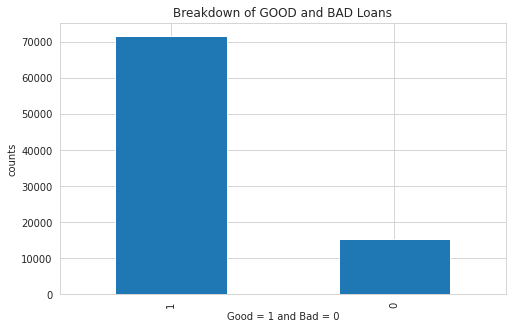

In [ ]:
plt.figure(figsize=(8,5))
ax = data['loan_status'].value_counts().plot(kind='bar',title='Breakdown of GOOD and BAD Loans')
ax.set_xlabel("Good = 1 and Bad = 0" )
ax.set_ylabel("counts")

# Distribution of loan amounts

Text(0, 0.5, 'Relative Frequency')

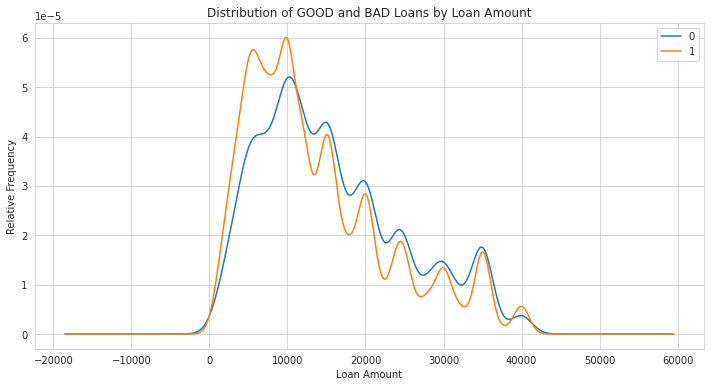

In [ ]:
plt.figure(figsize=(12,6))
ax = data.groupby('loan_status').loan_amnt.plot(kind='kde', title='Distribution of GOOD and BAD Loans by Loan Amount' , legend = True)
plt.xlabel('Loan Amount')
plt.ylabel('Relative Frequency')

# Distribution of Loan Status by Principal Amount Received  

Text(0, 0.5, 'Relative Frequency')

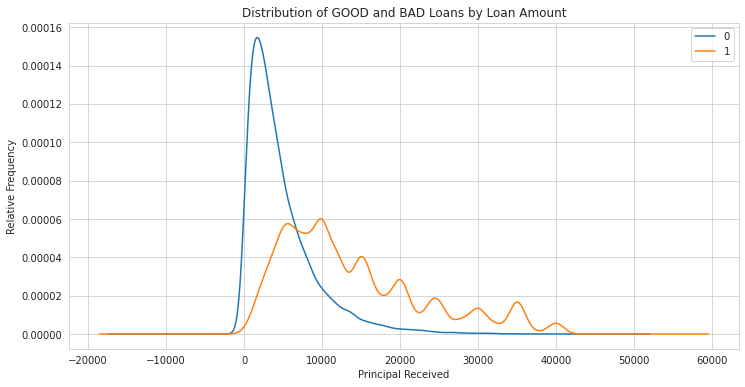

In [ ]:
plt.figure(figsize=(12,6))
ax = data.groupby('loan_status').total_rec_prncp.plot(kind='kde', title='Distribution of GOOD and BAD Loans by Loan Amount' , legend = True) 
plt.xlabel('Principal Received')
plt.ylabel('Relative Frequency')


# Distribution of Annual Income

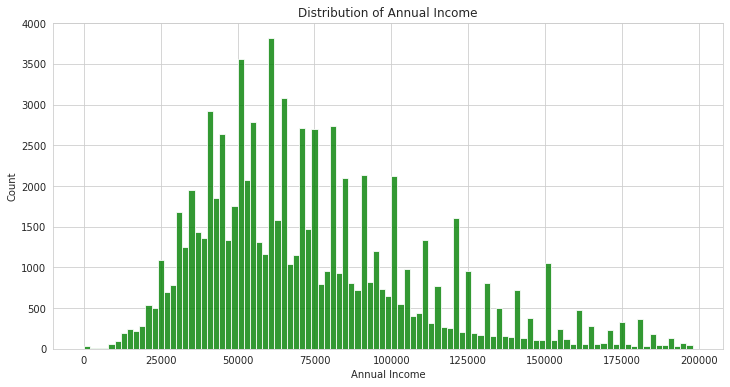

In [ ]:
datatemp = data['annual_inc']
bins = np.arange(datatemp.min(), 200000, 2000)
plt.figure(figsize=(12,6))
g1 = plt.hist(datatemp, 
         bins=bins, 
         alpha=0.8, 
         color='green')
plt.title('Distribution of Annual Income')
plt.xlabel('Annual Income')
plt.ylabel('Count')
plt.show()

# Loan Grades

In [ ]:
loan_grade = ['loan_status', 'grade']
cm = sns.light_palette("green", as_cmap=True)
pd.crosstab(data[loan_grade[0]], data[loan_grade[1]]).style.background_gradient(cmap = cm)

grade,A,B,C,D,E,F,G
loan_status,,,,,,,
0,674,3107,5977,3016,1581,683,210
1,14033,24061,22160,7668,2708,794,235


# Home Ownership vs Loan Amount

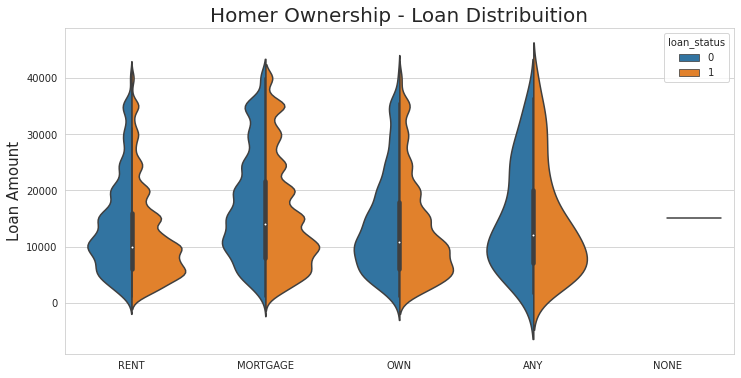

In [ ]:

plt.figure(figsize = (12,6))
g = sns.violinplot(x="home_ownership",y="loan_amnt",data=data,
               kind="violin",
               split = True,  hue="loan_status")
g.set_title("Homer Ownership - Loan Distribuition", fontsize=20)
g.set_xlabel("", fontsize=15)
g.set_ylabel("Loan Amount", fontsize=15)

plt.show()

# #### Credit Rating versus Loan Amount 

# #### Credit Rating versus Interest Rate

In [ ]:
data['int_rate'].dtypes

dtype('O')

## There are also some columns that represent numeric values, that need to be converted:

## **int_rate:** interest rate of the loan in %,

### **revol_util**: revolving line utilization rate or the amount of credit the borrower is using relative to all available credit

## Changing the data of int_rate and revol_util  from object to float

In [17]:
data["int_rate"]  = data['int_rate'].str.rstrip("%").astype("float")

In [18]:
data["revol_util"]  = data['revol_util'].str.rstrip("%").astype("float")

# Distribution of Good and Bad Loans by Interest Rates

Text(0, 0.5, 'Relative Frequency')

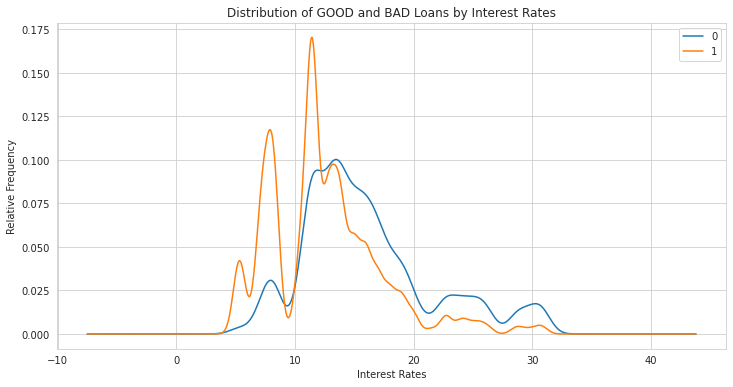

In [ ]:
plt.figure(figsize=(12,6))
ax = data.groupby('loan_status').int_rate.plot(kind='kde', title='Distribution of GOOD and BAD Loans by Interest Rates' , legend = True)
plt.xlabel('Interest Rates')
plt.ylabel('Relative Frequency')

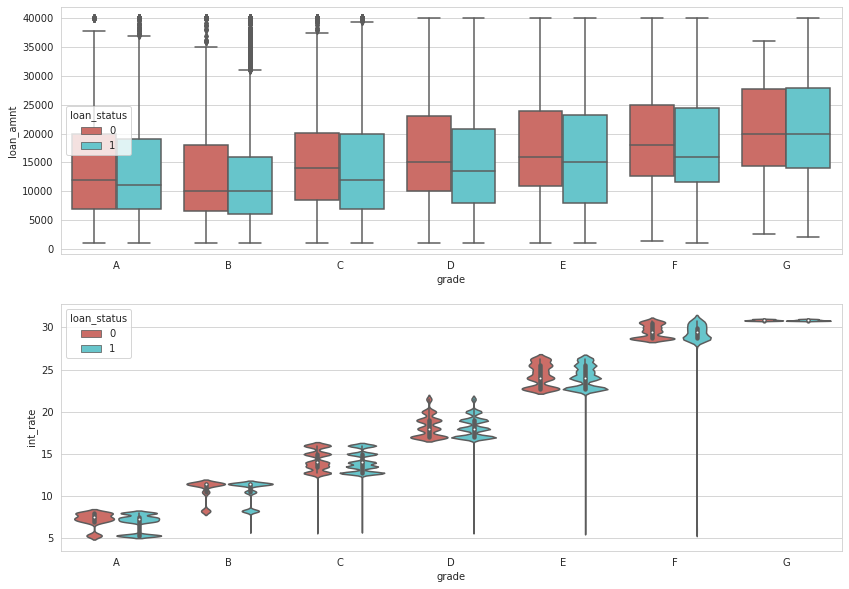

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(14,10))
sns.boxplot(x = "grade" , y = "loan_amnt" , data = data , hue = "loan_status" , order = ["A" , "B" , "C" , "D" , "E" , "F" , "G"] , ax = ax[0] , palette = "hls" )

sns.violinplot(x = "grade" , y = "int_rate" , data = data , hue = "loan_status" , ax = ax[1] , palette = "hls" , order = ["A" , "B" , "C" , "D" , "E" , "F" , "G"])

plt.show()

# Breakdown of Employment Length

In [ ]:
datatemp2 = data['emp_length'].value_counts()

In [ ]:
datatemp2

10+ years    29470
2 years       8213
3 years       7404
< 1 year      6314
1 year        5790
5 years       5461
4 years       5221
6 years       3797
9 years       3179
7 years       2881
8 years       2861
Name: emp_length, dtype: int64

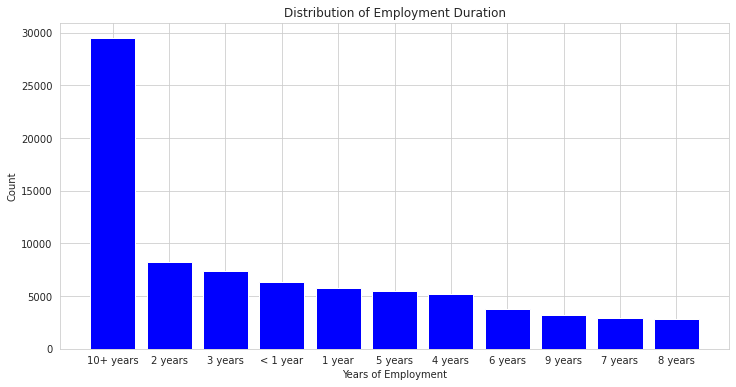

In [ ]:
datatemp3 = ['10+ years','2 years','3 years','< 1 year','1 year','5 years','4 years','6 years','9 years','7 years','8 years']
plt.figure(figsize=(12,6))
g2 = plt.bar(datatemp3, datatemp2, color='blue')
plt.title('Distribution of Employment Duration')
plt.xlabel('Years of Employment')
plt.ylabel('Count')
plt.show()

# Breakdown of Loan Purpose

In [ ]:
datatemp4 = data['purpose'].value_counts()

In [ ]:
datatemp4

debt_consolidation    48755
credit_card           18866
home_improvement       6326
other                  5719
major_purchase         2004
medical                1258
car                    1052
small_business         1052
vacation                762
moving                  670
house                   382
renewable_energy         61
Name: purpose, dtype: int64

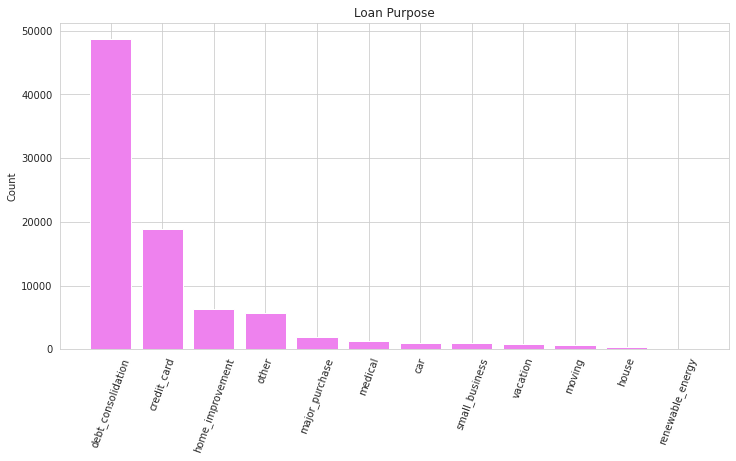

In [ ]:
datatemp5 = ['debt_consolidation', 'credit_card' , 'home_improvement', 'other','major_purchase',\
'medical','car', 'small_business','vacation', 'moving' , 'house','renewable_energy']
plt.figure(figsize=(12,6))
g2 = plt.bar(datatemp5, datatemp4, color='violet')
plt.title('Loan Purpose')
# plt.xlabel('Years of Employment')
plt.ylabel('Count')
plt.xticks(rotation=70)
plt.show()

# Analysis of Loan Terms  

Text(0, 0.5, 'counts')

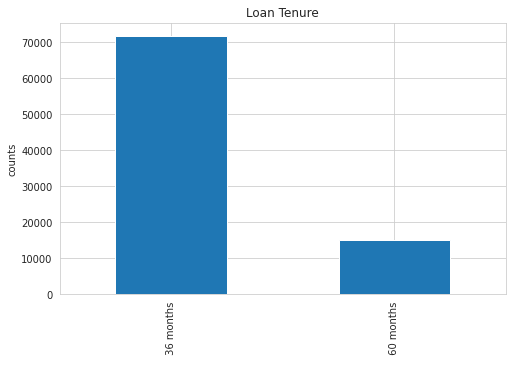

In [ ]:
plt.figure(figsize=(8,5))
ax = data['term'].value_counts().plot(kind='bar',title='Loan Tenure')
ax.set_ylabel("counts")

# **Data Processing and Cleaning**

## Data types of features of type Object in the data dataset 

In [19]:
Objects_Columns_df = data.select_dtypes(include = ["object"])

In [20]:
print(Objects_Columns_df.iloc[0])

id                                                              103952006
term                                                            60 months
grade                                                                   C
sub_grade                                                              C1
emp_title                                           Relocation Specialist
emp_length                                                        9 years
home_ownership                                                       RENT
verification_status                                          Not Verified
issue_d                                                            Mar-17
pymnt_plan                                                              n
url                     https://lendingclub.com/browse/loanDetail.acti...
purpose                                                debt_consolidation
title                                                  Debt consolidation
zip_code                              

## The id and url features don't serve much purpose and can be dropped 

In [21]:
Insignificant =  ["url" , "id"]
data.drop(Insignificant , axis = 1 , inplace = True)

## mapping the emp_length feature

In [22]:
mapping_dict = {
    "emp_length": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "n/a": 0
    }
  
}

In [23]:
data = data.replace(mapping_dict)

In [24]:
Objects_Columns_df = data.select_dtypes(include = ["object"])

In [25]:
for i in Objects_Columns_df:
  print(data[i].value_counts())

 36 months    71867
 60 months    15040
Name: term, dtype: int64
C    28137
B    27168
A    14707
D    10684
E     4289
F     1477
G      445
Name: grade, dtype: int64
C1    7393
B5    7383
B1    6055
C4    5408
C2    5365
B4    5122
C5    5075
C3    4896
B3    4409
B2    4199
A1    3917
D1    3746
A5    3315
D2    2651
A4    2646
D3    2480
A2    2464
A3    2365
E1    1420
D4    1399
E2     987
E4     737
F1     618
E5     592
E3     553
D5     408
F2     261
F3     227
F4     200
F5     171
G1     134
G2     109
G3      78
G5      72
G4      52
Name: sub_grade, dtype: int64
Teacher                                     1634
Manager                                     1464
Owner                                       1244
Driver                                       694
RN                                           645
                                            ... 
Doc Specialist                                 1
Custodial coordinator                          1
AVP, BSA Officer         

In [26]:
data_object = []

for i in Objects_Columns_df:
  data_object.append(data[i])

In [27]:
data_category = pd.DataFrame(data_object)

In [ ]:
data_category.head()

,term,grade,sub_grade,emp_title,home_ownership,verification_status,issue_d,pymnt_plan,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag,debt_settlement_flag
0,60 months,C,C1,Relocation Specialist,RENT,Not Verified,Mar-17,n,debt_consolidation,Debt consolidation,980xx,WA,May-90,w,Dec-18,May-19,Individual,N,N
1,36 months,A,A4,Line worker,RENT,Not Verified,Mar-17,n,debt_consolidation,Debt consolidation,196xx,PA,Aug-09,w,Aug-18,May-20,Individual,N,N
2,36 months,B,B4,Accounts Payable Coordinator,RENT,Not Verified,Mar-17,n,debt_consolidation,Debt consolidation,606xx,IL,Sep-02,w,Mar-20,Apr-20,Individual,N,N
3,36 months,A,A2,Recruiter,MORTGAGE,Not Verified,Mar-17,n,vacation,Vacation,301xx,GA,Oct-94,w,Mar-20,May-20,Individual,N,N
4,36 months,B,B3,SUPERINTENDANT,MORTGAGE,Not Verified,Mar-17,n,medical,Medical expenses,761xx,TX,Apr-00,w,Oct-18,Apr-19,Individual,N,N


In [28]:
data_category = data_category.transpose()

In [ ]:
data_category.head()

,term,grade,sub_grade,emp_title,home_ownership,verification_status,issue_d,pymnt_plan,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag,debt_settlement_flag
0,60 months,C,C1,Relocation Specialist,RENT,Not Verified,Mar-17,n,debt_consolidation,Debt consolidation,980xx,WA,May-90,w,Dec-18,May-19,Individual,N,N
1,36 months,A,A4,Line worker,RENT,Not Verified,Mar-17,n,debt_consolidation,Debt consolidation,196xx,PA,Aug-09,w,Aug-18,May-20,Individual,N,N
2,36 months,B,B4,Accounts Payable Coordinator,RENT,Not Verified,Mar-17,n,debt_consolidation,Debt consolidation,606xx,IL,Sep-02,w,Mar-20,Apr-20,Individual,N,N
3,36 months,A,A2,Recruiter,MORTGAGE,Not Verified,Mar-17,n,vacation,Vacation,301xx,GA,Oct-94,w,Mar-20,May-20,Individual,N,N
4,36 months,B,B3,SUPERINTENDANT,MORTGAGE,Not Verified,Mar-17,n,medical,Medical expenses,761xx,TX,Apr-00,w,Oct-18,Apr-19,Individual,N,N


In [ ]:
data_category['zip_code'].unique()

array(['980xx', '196xx', '606xx', '301xx', '761xx', '852xx', '941xx',
       '773xx', '067xx', '307xx', '983xx', '926xx', '068xx', '433xx',
       '021xx', '087xx', '672xx', '850xx', '329xx', '913xx', '112xx',
       '840xx', '751xx', '070xx', '467xx', '864xx', '324xx', '454xx',
       '066xx', '768xx', '981xx', '486xx', '224xx', '367xx', '190xx',
       '088xx', '902xx', '945xx', '950xx', '600xx', '187xx', '101xx',
       '847xx', '480xx', '577xx', '593xx', '917xx', '640xx', '463xx',
       '882xx', '928xx', '185xx', '300xx', '113xx', '331xx', '633xx',
       '900xx', '750xx', '349xx', '379xx', '321xx', '100xx', '802xx',
       '630xx', '689xx', '372xx', '605xx', '366xx', '320xx', '441xx',
       '921xx', '777xx', '841xx', '724xx', '476xx', '925xx', '482xx',
       '971xx', '906xx', '752xx', '974xx', '281xx', '955xx', '151xx',
       '993xx', '967xx', '282xx', '335xx', '933xx', '342xx', '801xx',
       '155xx', '334xx', '212xx', '280xx', '542xx', '243xx', '290xx',
       '103xx', '660

In [ ]:
data_category['addr_state'].unique()

array(['WA', 'PA', 'IL', 'GA', 'TX', 'AZ', 'CA', 'CT', 'OH', 'MA', 'NJ',
       'KS', 'FL', 'NY', 'UT', 'IN', 'MI', 'VA', 'AL', 'SD', 'MT', 'MO',
       'NM', 'TN', 'CO', 'NE', 'AR', 'OR', 'NC', 'HI', 'MD', 'WI', 'SC',
       'MN', 'NV', 'OK', 'LA', 'ND', 'MS', 'VT', 'RI', 'KY', 'AK', 'ME',
       'NH', 'DC', 'WY', 'ID', 'DE'], dtype=object)

### The addr_state and Zip Code columns contains many discrete values and I need to add many dummy variable columns to use it for classification. This would make the Dataframe much larger and could slow down how quickly the code runs. 

# **But the income levels may differ from state to state, though I will have to create 49 dummy columns but I am retaining addr_state feature to avoid missing any important feature and being on safer side.*** 

# removing zip_code as last 2 digits of Zip Code are hidden and also creating extra 612 dummy columns for each of the Zip Codes will slow down the code execution drastically.

In [29]:
Insignificant = [ "zip_code"]

In [30]:
data.drop(Insignificant , axis = 1 , inplace = True )

In [ ]:
data_category['pymnt_plan'].unique()

array(['n'], dtype=object)

### some of the columns contain date values that would require a good amount of feature engineering for them to be potentially useful:

## **earliest_cr_line: The month the borrower's earliest reported credit line was opened,**

## **last_credit_pull_d: The most recent month Lending Club pulled credit for this loa**n.

## Since these date features require some feature engineering for modeling purposes, let's remove these date columns from the Dataframe.

In [ ]:
data['earliest_cr_line'].unique()

array(['May-90', 'Aug-09', 'Sep-02', 'Oct-94', 'Apr-00', 'Aug-95',
       'Jun-05', 'Sep-04', 'Jan-04', 'Apr-06', 'Oct-07', 'Aug-02',
       'Dec-98', 'Apr-07', 'Sep-05', 'May-96', 'May-94', 'Apr-73',
       'Dec-97', 'Mar-01', 'Jan-05', 'Nov-74', 'Apr-87', 'Aug-92',
       'Dec-89', 'Mar-97', 'Apr-05', 'Dec-03', 'Apr-03', 'May-99',
       'Oct-05', 'Jul-04', 'Nov-98', 'Oct-95', 'Aug-89', 'Sep-80',
       'Aug-93', 'Oct-96', 'Aug-05', 'Sep-99', 'Feb-99', 'Sep-94',
       'Jun-02', 'Oct-01', 'Dec-06', 'Apr-97', 'Jul-95', 'Dec-01',
       'Apr-02', 'Nov-01', 'Mar-85', 'Mar-99', 'Apr-96', 'Jul-13',
       'Jan-02', 'Jun-91', 'Mar-91', 'Feb-04', 'May-05', 'Jun-09',
       'May-02', 'Aug-07', 'Mar-92', 'Sep-11', 'Mar-79', 'Jul-05',
       'Feb-06', 'Dec-95', 'May-07', 'Aug-99', 'Feb-07', 'Dec-94',
       'May-03', 'Nov-88', 'May-91', 'Jan-13', 'Mar-83', 'Dec-05',
       'Sep-01', 'Jul-08', 'Jan-10', 'Jun-01', 'Dec-10', 'Jul-98',
       'Apr-09', 'Jun-94', 'Jun-00', 'Jan-81', 'Jan-07', 'Jan-

In [ ]:
data['last_credit_pull_d'].value_counts()

May-20    29131
Mar-20    10519
Jan-20     5752
Apr-20     3784
Nov-19     3426
Feb-20     2334
Oct-19     1989
Sep-19     1954
Jul-19     1805
Jul-18     1738
Aug-19     1669
Jun-19     1518
Feb-19     1494
Apr-19     1487
May-19     1380
Dec-19     1301
Mar-19     1294
Oct-18     1255
Jan-19     1240
Nov-18     1020
Aug-18     1018
Dec-18      954
Sep-18      954
Apr-18      824
May-18      814
Mar-18      783
Feb-18      761
Jan-18      738
Dec-17      572
Nov-17      555
Oct-17      496
Sep-17      489
Aug-17      360
Jul-17      275
Mar-17      250
Jun-17      227
May-17      217
Apr-17      170
Jun-18      143
Feb-17      123
Jan-17       81
Dec-16       12
Name: last_credit_pull_d, dtype: int64

In [31]:
data = data.drop(["last_credit_pull_d", "earliest_cr_line"], axis=1)

## last_payment_d -> Last month payment was received seems insigficant , dropping this feature

In [32]:
data = data.drop(["last_pymnt_d"], axis=1)

## The Purpose and Title features contain overlapping values , one of them can be dropped 

In [ ]:
print(data["title"].value_counts())
print("****************************************")
print(data["purpose"].value_counts())

Debt consolidation         48748
Credit card refinancing    18875
Home improvement            6325
Other                       5719
Major purchase              2000
Medical expenses            1258
Car financing               1055
Business                    1053
Vacation                     762
Moving and relocation        670
Home buying                  382
Green loan                    60
Name: title, dtype: int64
****************************************
debt_consolidation    48755
credit_card           18866
home_improvement       6326
other                  5719
major_purchase         2004
medical                1258
car                    1052
small_business         1052
vacation                762
moving                  670
house                   382
renewable_energy         61
Name: purpose, dtype: int64


## sub-grade feature contains redundant information and can be dropped 

## Features :  emp_title and issue_d -> date loan was funded are not relevant , can be dropped) 

In [33]:
Insignificant_Features = ["sub_grade" , "title" , "emp_title" , "issue_d" ] 

data.drop(Insignificant_Features , axis = 1 , inplace = True)

In [34]:
Objects_Columns_df = data.select_dtypes(include = ["object"])

In [35]:
print(Objects_Columns_df.iloc[0])

term                             60 months
grade                                    C
home_ownership                        RENT
verification_status           Not Verified
pymnt_plan                               n
purpose                 debt_consolidation
addr_state                              WA
initial_list_status                      w
application_type                Individual
hardship_flag                            N
debt_settlement_flag                     N
Name: 0, dtype: object


In [36]:
data_object = []

for i in Objects_Columns_df:
  data_object.append(data[i])

In [37]:
data_categorical = pd.DataFrame(data_object)

In [38]:
data_categorical = data_categorical.transpose()

In [39]:
data_categorical.shape

(86907, 11)

In [ ]:
data_categorical.head()

,term,grade,home_ownership,verification_status,pymnt_plan,purpose,addr_state,initial_list_status,application_type,hardship_flag,debt_settlement_flag
0,60 months,C,RENT,Not Verified,n,debt_consolidation,WA,w,Individual,N,N
1,36 months,A,RENT,Not Verified,n,debt_consolidation,PA,w,Individual,N,N
2,36 months,B,RENT,Not Verified,n,debt_consolidation,IL,w,Individual,N,N
3,36 months,A,MORTGAGE,Not Verified,n,vacation,GA,w,Individual,N,N
4,36 months,B,MORTGAGE,Not Verified,n,medical,TX,w,Individual,N,N


## Since all the 11 object variables are categorical and not ordinal, applying Label Encoding to change their data types

In [40]:
categorical_columns = ["term",  
"grade",                                                
"home_ownership" ,                            
"verification_status",                                             
"pymnt_plan",                                  
"purpose", 
"addr_state",                                                
"initial_list_status",                                                     
"application_type",                     
"hardship_flag",                                 
"debt_settlement_flag" ]

In [41]:
df_dummies = pd.get_dummies(data[categorical_columns])

In [42]:
df_dummies.shape

(86907, 87)

In [43]:
Objects_Columns_df = data.select_dtypes(include = ["object"])

In [ ]:
for i in Objects_Columns_df:
  print(data[i].value_counts())

 36 months    71867
 60 months    15040
Name: term, dtype: int64
C    28137
B    27168
A    14707
D    10684
E     4289
F     1477
G      445
Name: grade, dtype: int64
MORTGAGE    42444
RENT        33927
OWN         10182
ANY           353
NONE            1
Name: home_ownership, dtype: int64
Source Verified    36130
Not Verified       26241
Verified           24536
Name: verification_status, dtype: int64
n    86907
Name: pymnt_plan, dtype: int64
debt_consolidation    48755
credit_card           18866
home_improvement       6326
other                  5719
major_purchase         2004
medical                1258
car                    1052
small_business         1052
vacation                762
moving                  670
house                   382
renewable_energy         61
Name: purpose, dtype: int64
CA    12178
TX     7478
NY     7225
FL     6042
IL     3408
NJ     3135
PA     2925
OH     2797
GA     2600
NC     2374
VA     2368
MI     2203
MD     2136
AZ     2010
MA     1972
WA    

In [45]:
data = pd.concat([data , df_dummies] , axis = 1)

In [46]:
data.drop(categorical_columns , axis = 1 , inplace = True)

In [47]:
data.shape

(86907, 147)

## Finding Columns having any null values in rows

In [48]:
data.columns[data.isnull().any()].tolist()

['emp_length',
 'dti',
 'revol_util',
 'mths_since_rcnt_il',
 'il_util',
 'all_util',
 'bc_open_to_buy',
 'bc_util',
 'mo_sin_old_il_acct',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'percent_bc_gt_75']

In [49]:
null_rows =  ['emp_length',
 'dti',
 'revol_util',
 'mths_since_rcnt_il',
 'il_util',
 'all_util',
 'bc_open_to_buy',
 'bc_util',
 'mo_sin_old_il_acct',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'percent_bc_gt_75']

In [50]:
data_null = data[null_rows]

In [ ]:
data_null.isnull().sum()

emp_length                6316
dti                         24
revol_util                  43
mths_since_rcnt_il        2409
il_util                  11814
all_util                     1
bc_open_to_buy             908
bc_util                    950
mo_sin_old_il_acct        2409
mths_since_recent_bc       870
mths_since_recent_inq     9977
percent_bc_gt_75           910
dtype: int64

## Replacing null values with mean , median , mode whichever applicable

In [51]:
data['emp_length'].fillna(10 , inplace = True)

In [52]:
data.dti.fillna(data.dti.mean(), inplace = True)

In [53]:
data.revol_util.fillna(data.revol_util.median(), inplace = True)

In [54]:
data['mths_since_rcnt_il'].fillna(7 , inplace = True)

In [55]:
data.il_util.fillna(data.il_util.mean(), inplace = True)

In [56]:
data.all_util.fillna(data.all_util.median(), inplace = True)

In [57]:
data.bc_open_to_buy.fillna(data.bc_open_to_buy.mean(), inplace = True)

In [58]:
data.bc_util.fillna(data.bc_util.mean(), inplace = True)

In [59]:
data['mo_sin_old_il_acct'].fillna(127 , inplace = True)

In [60]:
data['mths_since_recent_bc'].fillna(2 , inplace = True)

In [61]:
data['mths_since_recent_inq'].fillna(1 , inplace = True)

In [62]:
data.percent_bc_gt_75.fillna(data.percent_bc_gt_75.mean(), inplace = True)

### Checking Correlation between features and bertween features and target variable loan_status 


### Since we have 147 features , divide in 5 groups to analyse correlation :

In [ ]:
data_1 = data.iloc[ : , 0:32]

In [ ]:
data_1 = data_1.drop('loan_status' , axis = 1)

data_1 = pd.concat([data_1 , data['loan_status']] , axis = 1)

In [ ]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86907 entries, 0 to 96778
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             86907 non-null  float64
 1   funded_amnt           86907 non-null  float64
 2   funded_amnt_inv       86907 non-null  float64
 3   int_rate              86907 non-null  float64
 4   installment           86907 non-null  float64
 5   emp_length            86907 non-null  float64
 6   annual_inc            86907 non-null  float64
 7   dti                   86907 non-null  float64
 8   fico_range_low        86907 non-null  float64
 9   fico_range_high       86907 non-null  float64
 10  open_acc              86907 non-null  float64
 11  revol_bal             86907 non-null  float64
 12  revol_util            86907 non-null  float64
 13  total_acc             86907 non-null  float64
 14  total_pymnt           86907 non-null  float64
 15  total_pymnt_inv    

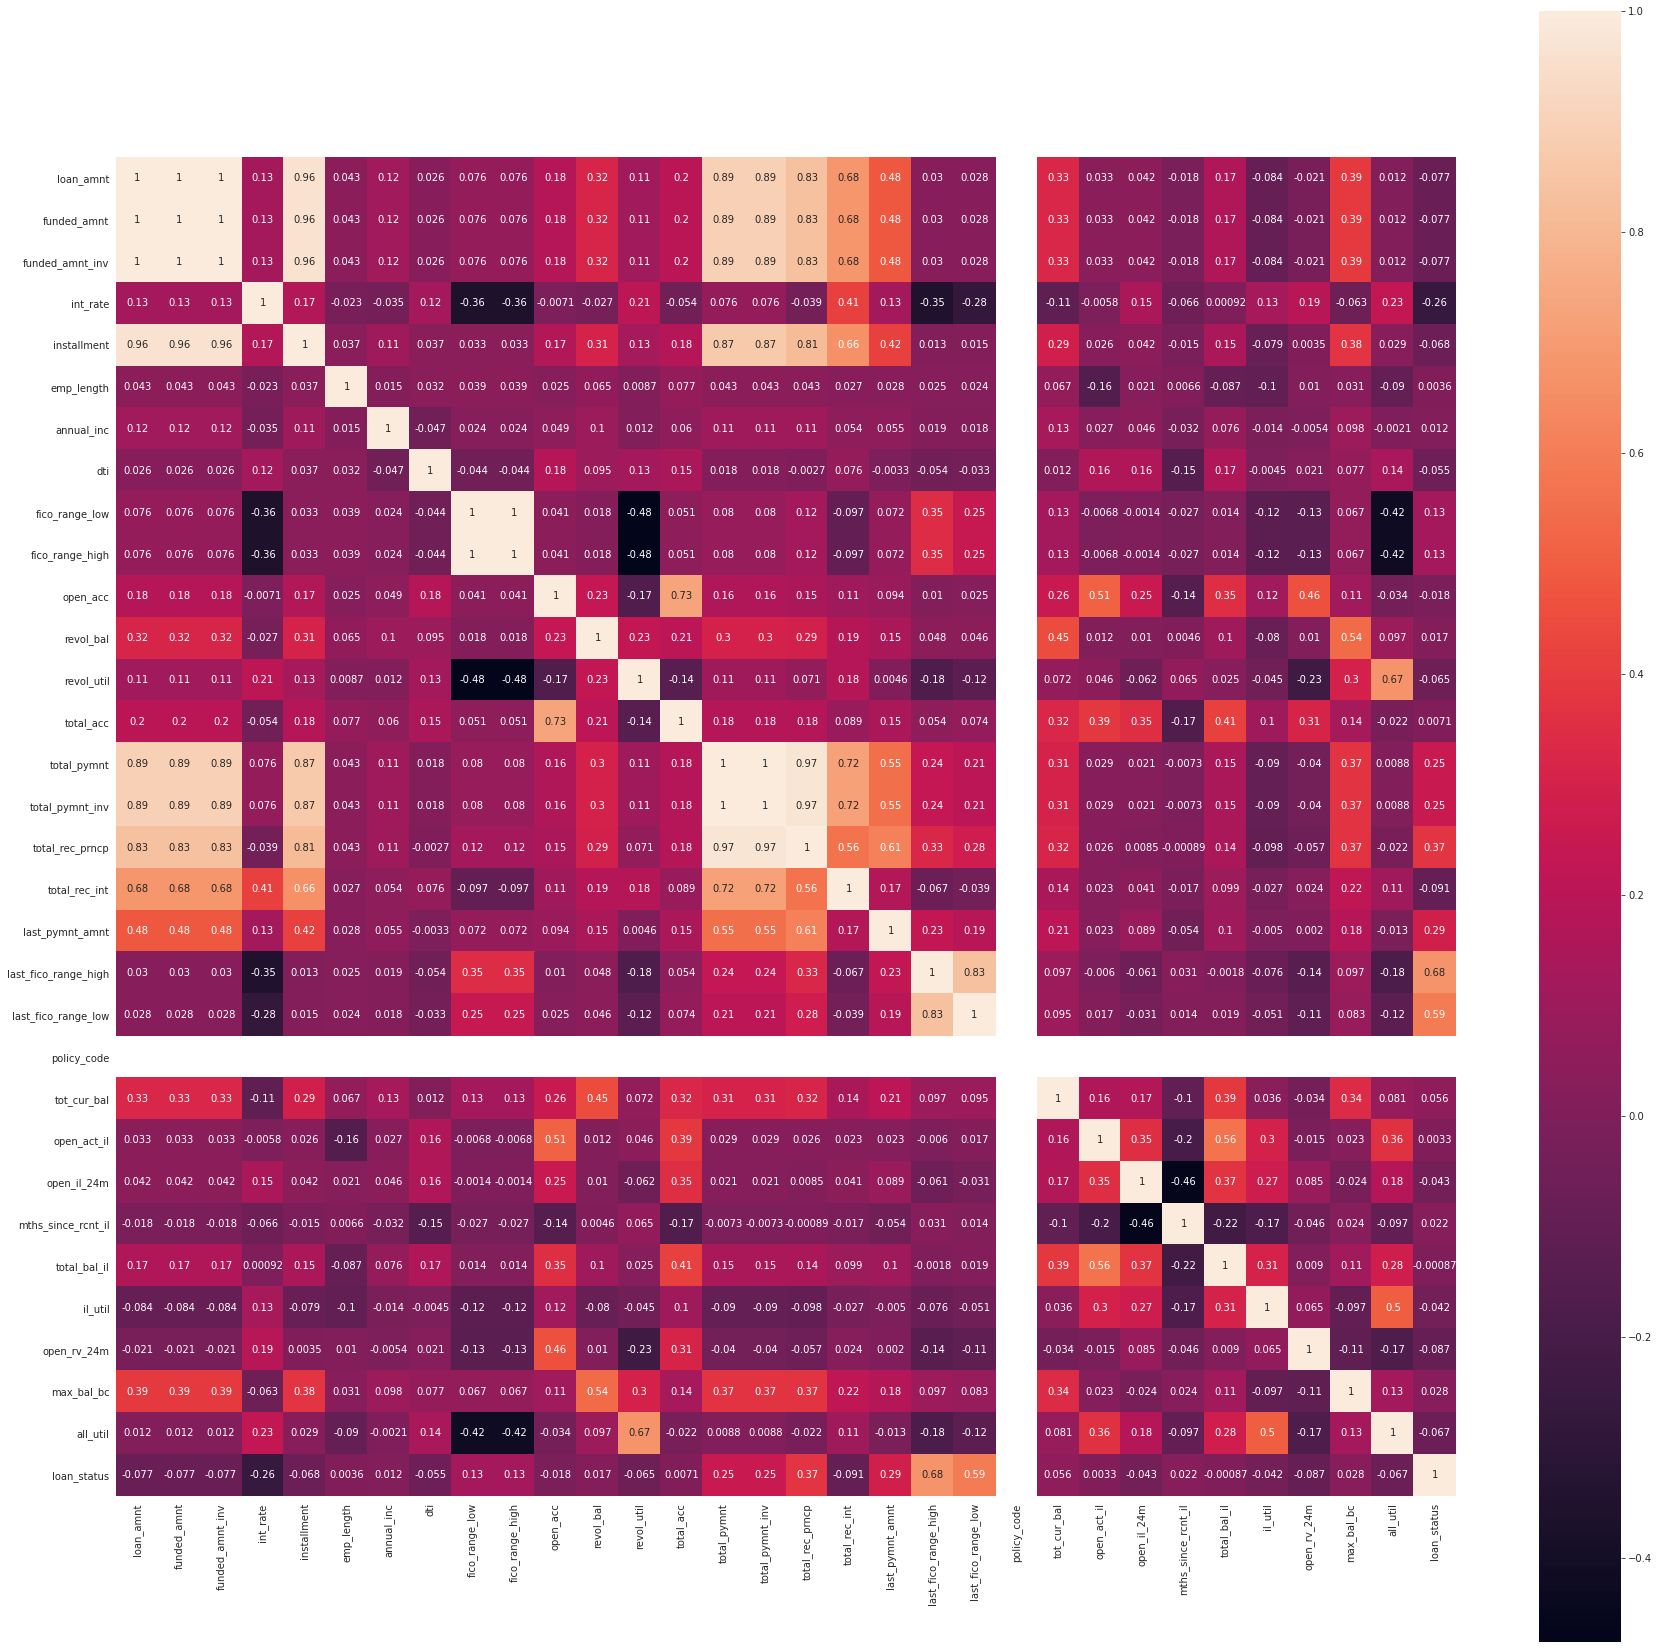

In [ ]:
# making pair plot for data_1

import seaborn as sns

plt.figure(figsize=(30,30))

sns.heatmap(data_1.corr(),annot = True , square = True)


In [ ]:
data_2 = data.iloc[ : , 32:65]
data_2 = pd.concat([data_2 , data['loan_status']] , axis = 1)



In [ ]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86907 entries, 0 to 96778
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   total_rev_hi_lim            86907 non-null  float64
 1   inq_last_12m                86907 non-null  float64
 2   acc_open_past_24mths        86907 non-null  float64
 3   avg_cur_bal                 86907 non-null  float64
 4   bc_open_to_buy              86907 non-null  float64
 5   bc_util                     86907 non-null  float64
 6   mo_sin_old_il_acct          86907 non-null  float64
 7   mo_sin_old_rev_tl_op        86907 non-null  float64
 8   mo_sin_rcnt_rev_tl_op       86907 non-null  float64
 9   mo_sin_rcnt_tl              86907 non-null  float64
 10  mths_since_recent_bc        86907 non-null  float64
 11  mths_since_recent_inq       86907 non-null  float64
 12  num_actv_bc_tl              86907 non-null  float64
 13  num_actv_rev_tl             869

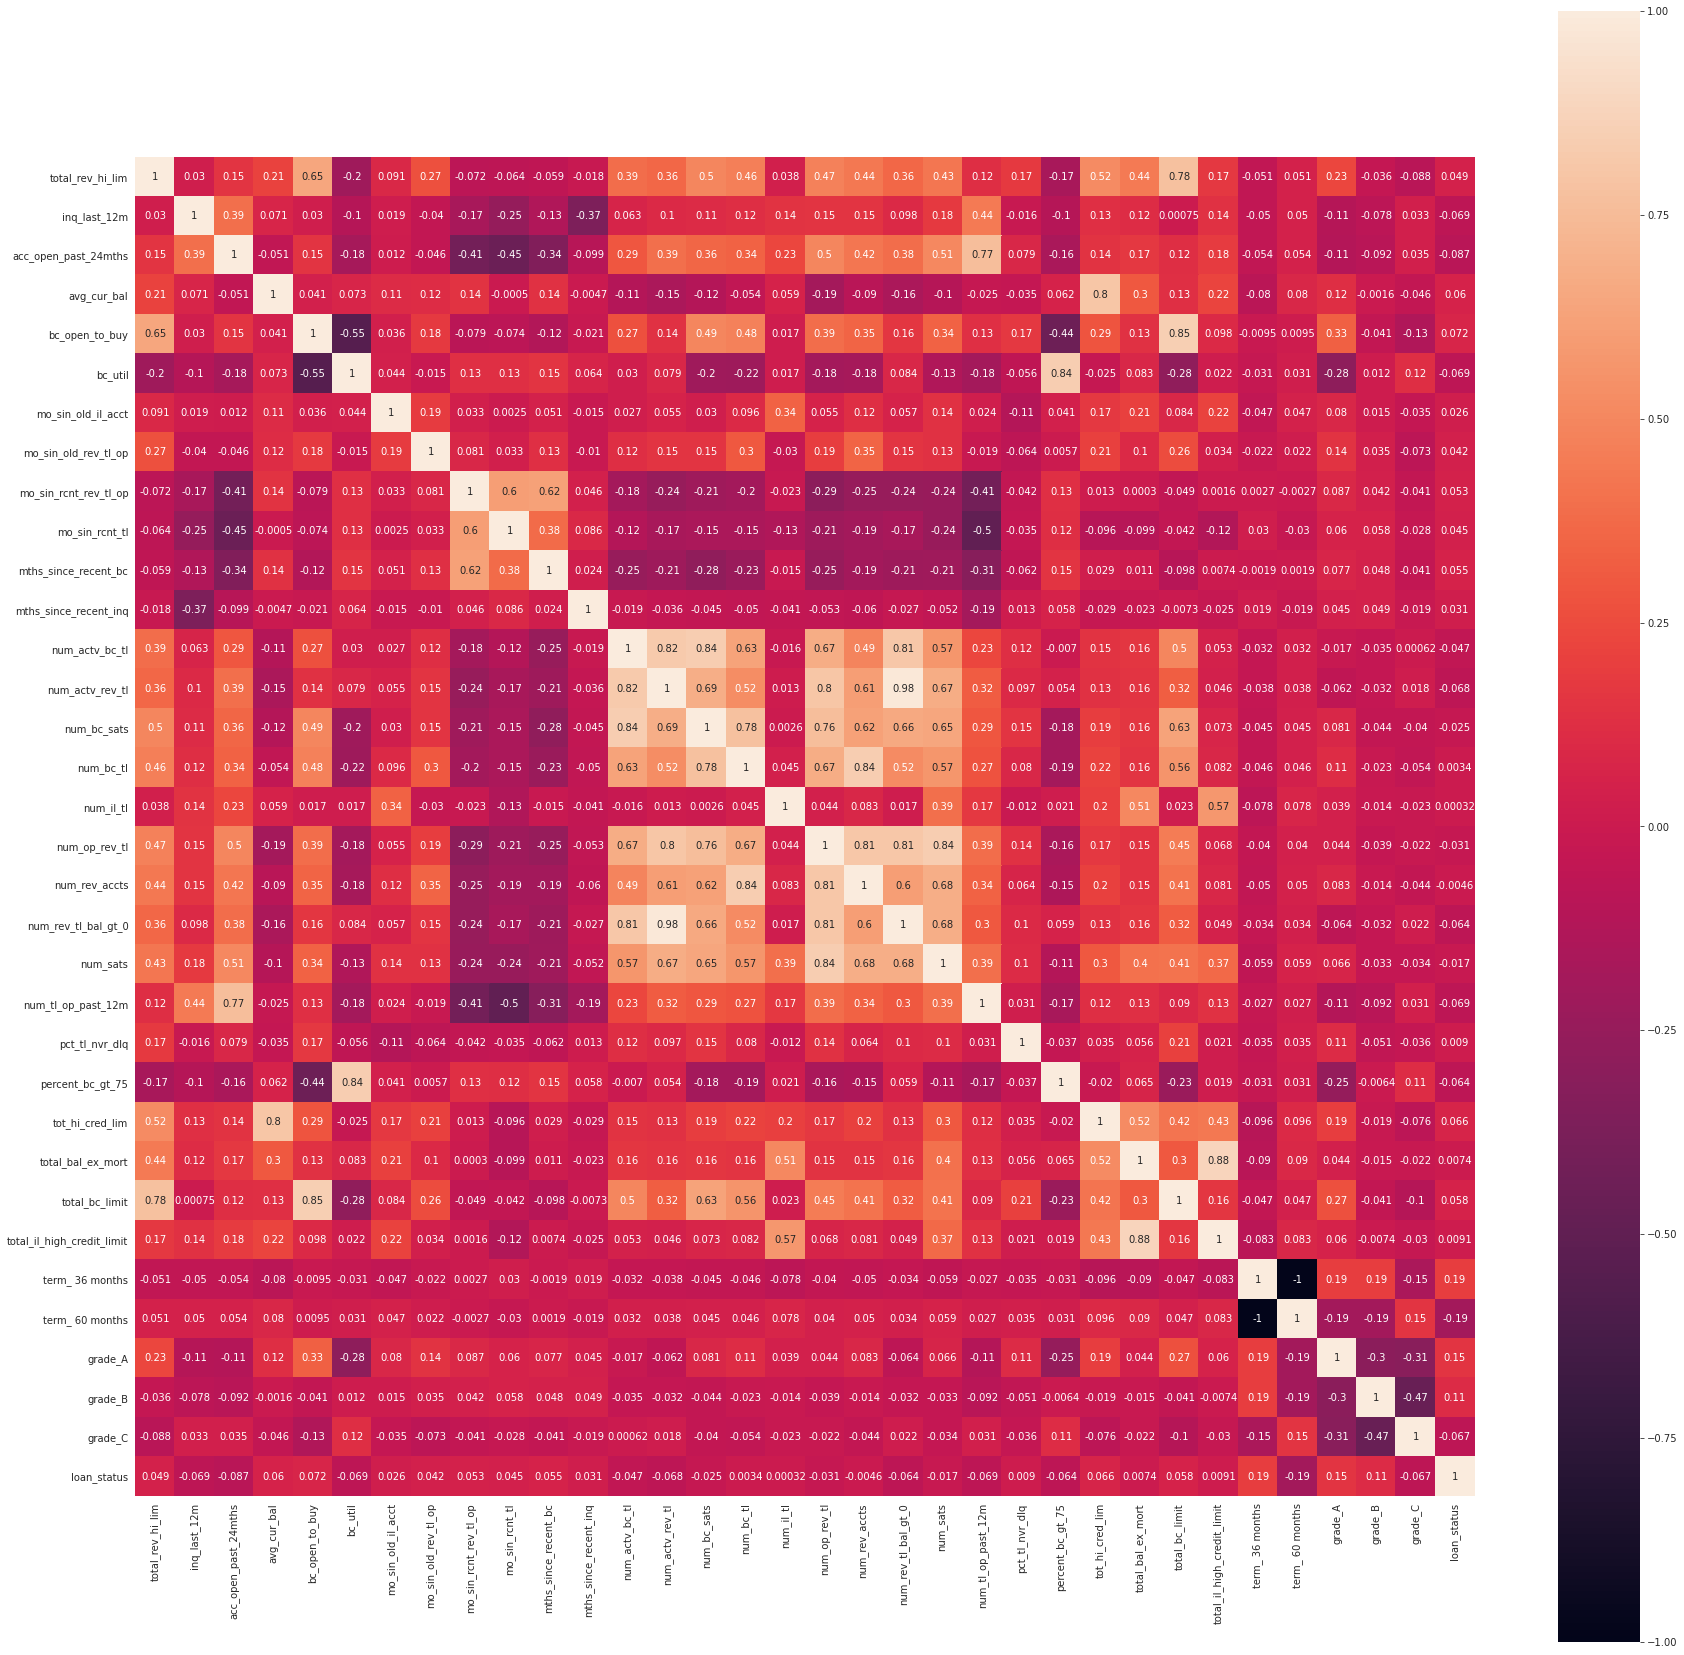

In [ ]:
# making pair plot for data_2

import seaborn as sns

plt.figure(figsize=(30,30))

sns.heatmap(data_2.corr(),annot = True , square = True)

In [ ]:
data_3 = data.iloc[ : , 65:98]
data_3 = pd.concat([data_3 , data['loan_status']] , axis = 1)

In [ ]:
data_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86907 entries, 0 to 96778
Data columns (total 34 columns):
 #   Column                               Non-Null Count  Dtype
---  ------                               --------------  -----
 0   grade_D                              86907 non-null  uint8
 1   grade_E                              86907 non-null  uint8
 2   grade_F                              86907 non-null  uint8
 3   grade_G                              86907 non-null  uint8
 4   home_ownership_ANY                   86907 non-null  uint8
 5   home_ownership_MORTGAGE              86907 non-null  uint8
 6   home_ownership_NONE                  86907 non-null  uint8
 7   home_ownership_OWN                   86907 non-null  uint8
 8   home_ownership_RENT                  86907 non-null  uint8
 9   verification_status_Not Verified     86907 non-null  uint8
 10  verification_status_Source Verified  86907 non-null  uint8
 11  verification_status_Verified         86907 non-null  u

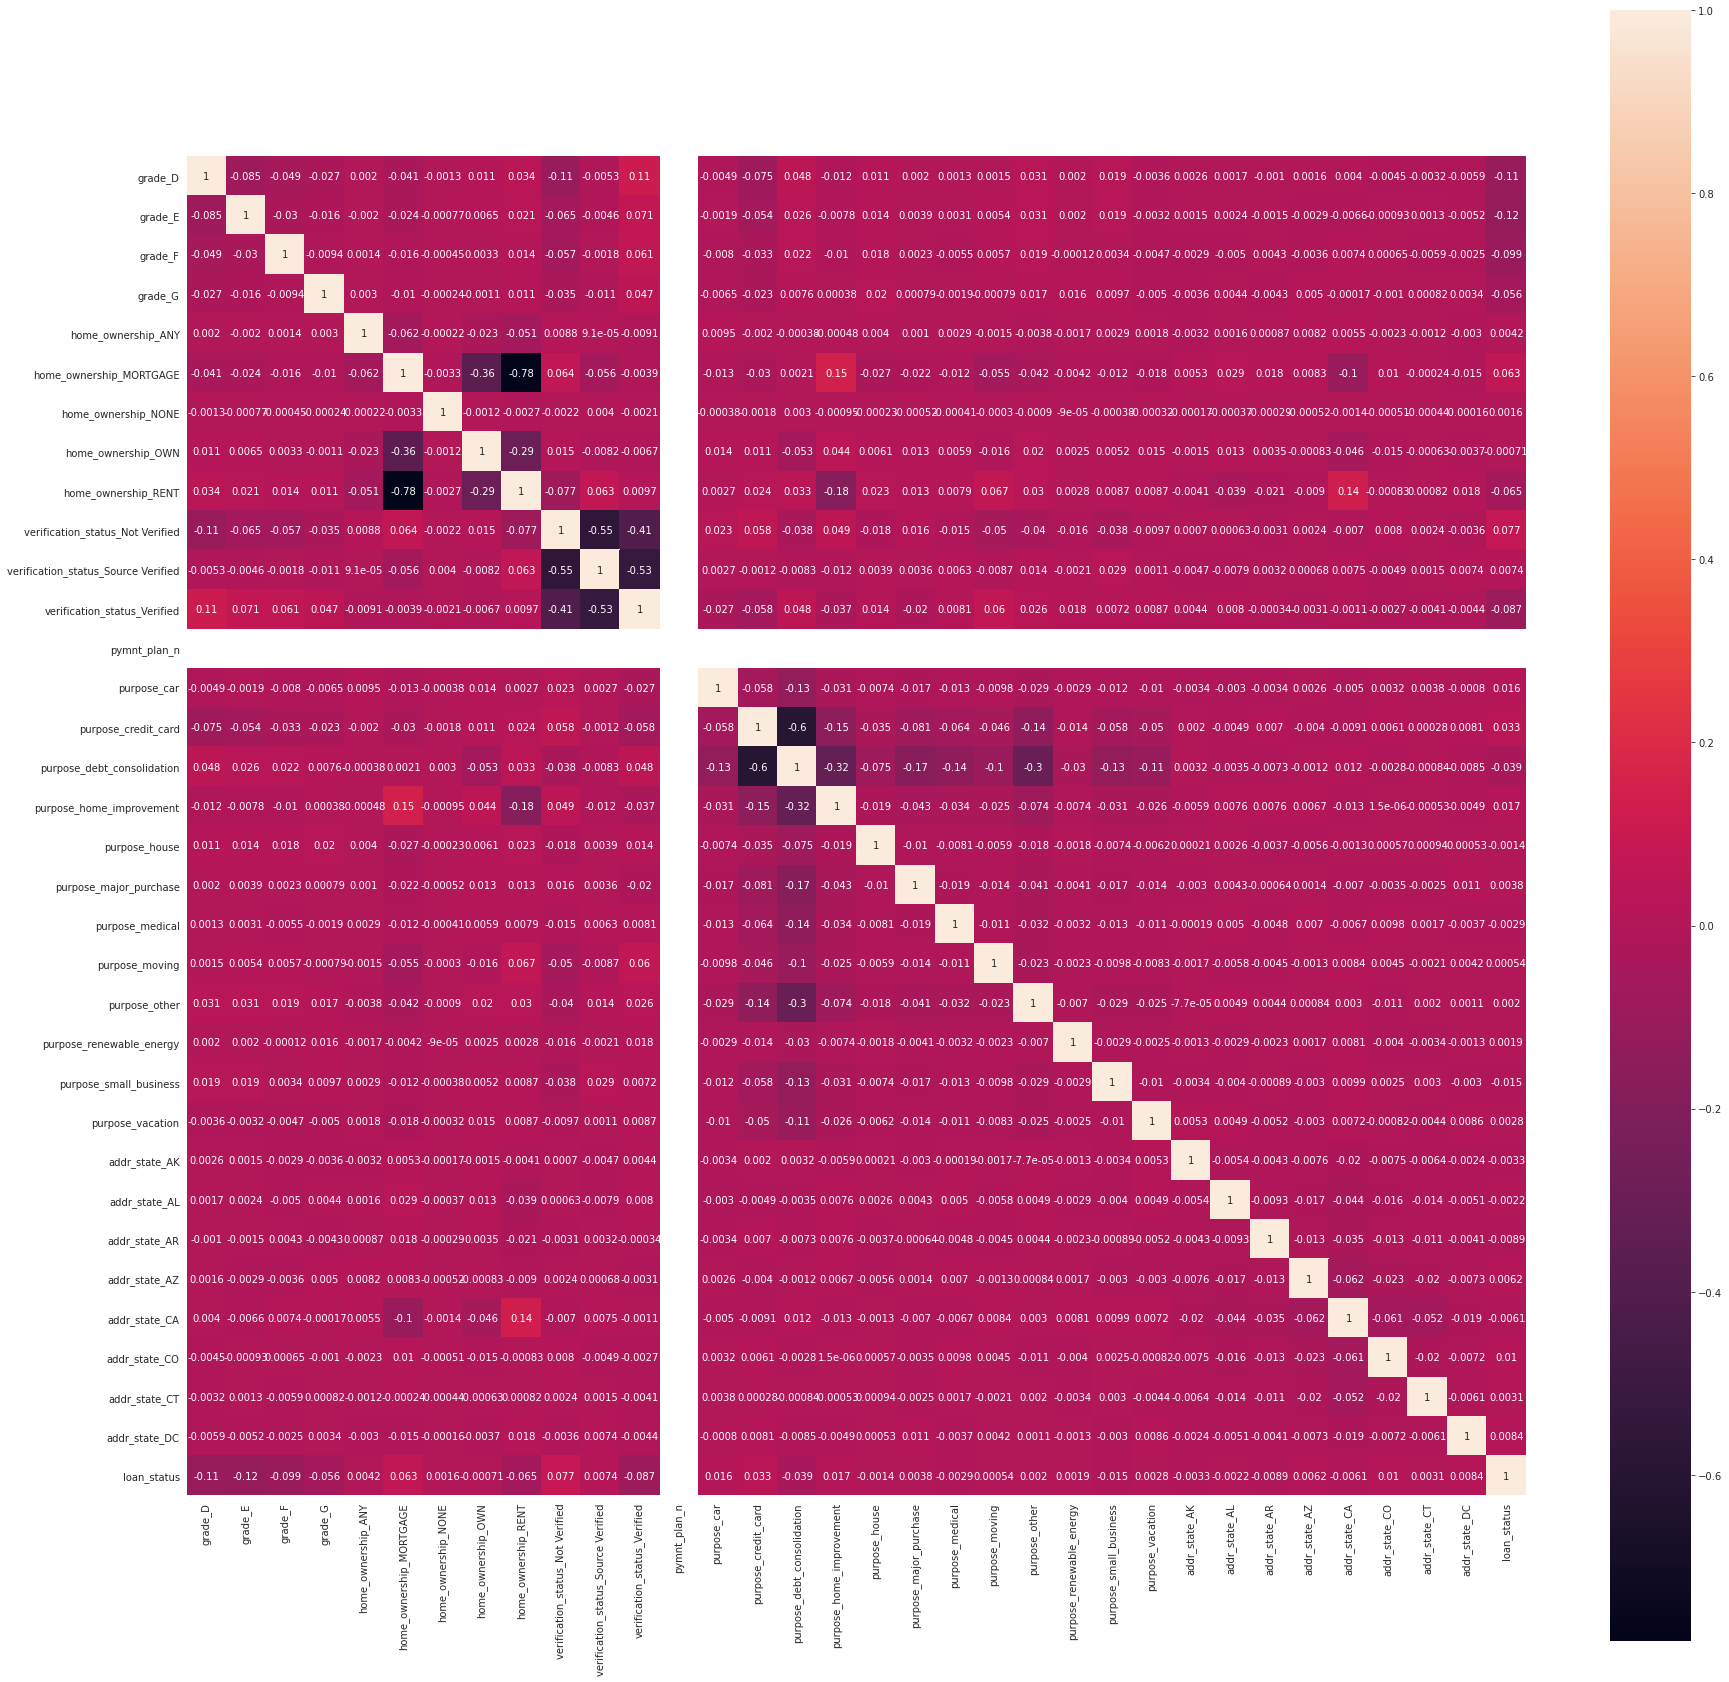

In [ ]:
# making pair plot for data_3

import seaborn as sns

plt.figure(figsize=(30,30))

sns.heatmap(data_3.corr(),annot = True , square = True)

In [ ]:
data_4 = data.iloc[ : ,98:130]
data_4 = pd.concat([data_4 , data['loan_status']] , axis = 1)

In [ ]:
data_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86907 entries, 0 to 96778
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   addr_state_DE  86907 non-null  uint8
 1   addr_state_FL  86907 non-null  uint8
 2   addr_state_GA  86907 non-null  uint8
 3   addr_state_HI  86907 non-null  uint8
 4   addr_state_ID  86907 non-null  uint8
 5   addr_state_IL  86907 non-null  uint8
 6   addr_state_IN  86907 non-null  uint8
 7   addr_state_KS  86907 non-null  uint8
 8   addr_state_KY  86907 non-null  uint8
 9   addr_state_LA  86907 non-null  uint8
 10  addr_state_MA  86907 non-null  uint8
 11  addr_state_MD  86907 non-null  uint8
 12  addr_state_ME  86907 non-null  uint8
 13  addr_state_MI  86907 non-null  uint8
 14  addr_state_MN  86907 non-null  uint8
 15  addr_state_MO  86907 non-null  uint8
 16  addr_state_MS  86907 non-null  uint8
 17  addr_state_MT  86907 non-null  uint8
 18  addr_state_NC  86907 non-null  uint8
 19  addr

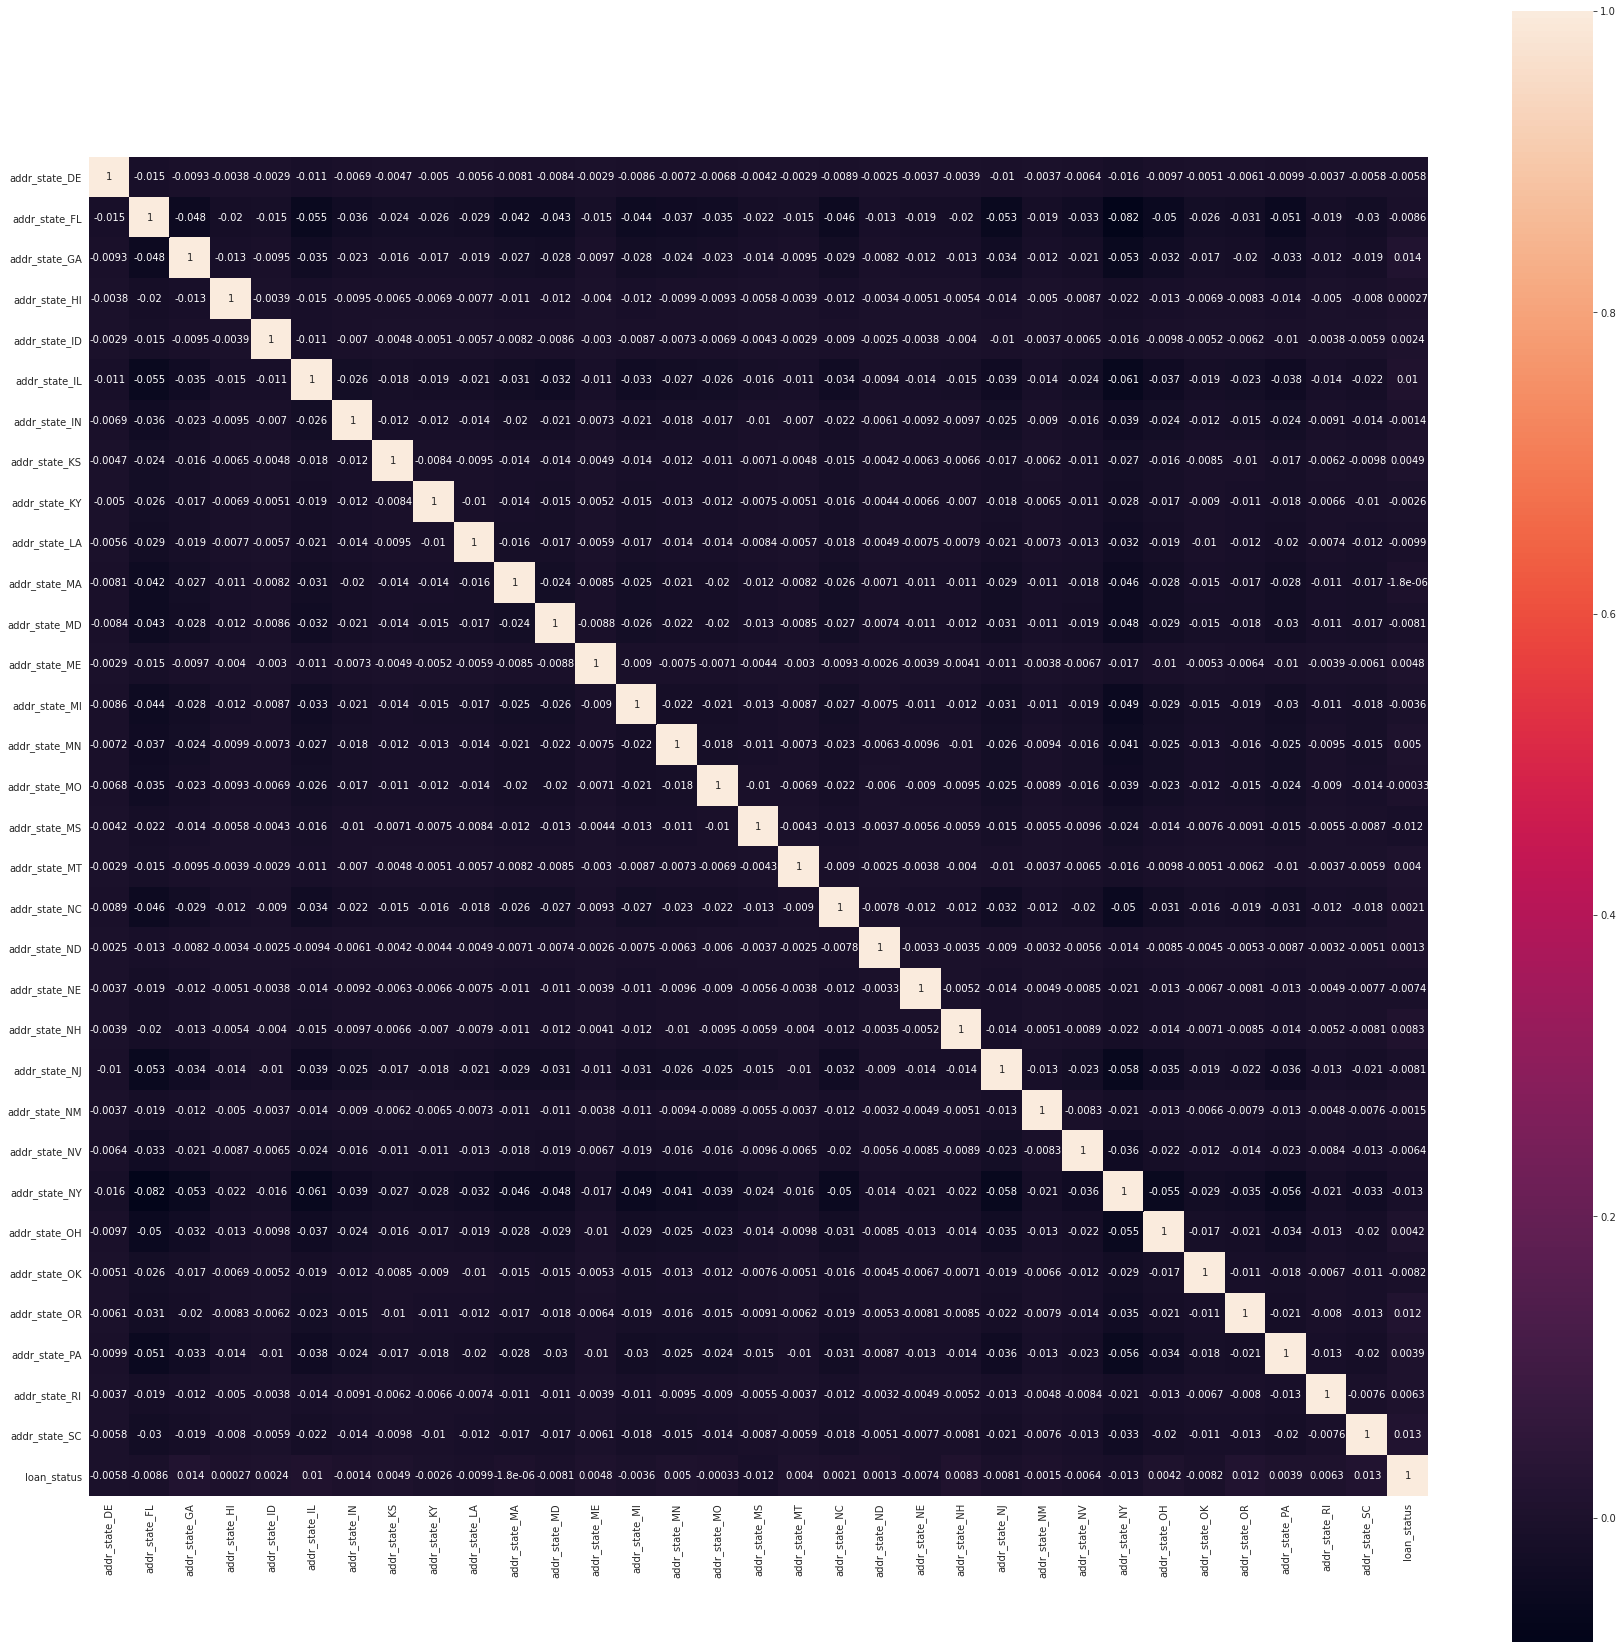

In [ ]:
# making pair plot for data_4

import seaborn as sns

plt.figure(figsize=(30,30))

sns.heatmap(data_4.corr(),annot = True , square = True)

In [ ]:
data_5 = data.iloc[ : ,130:]
data_5 = pd.concat([data_5 , data['loan_status']] , axis = 1)

In [ ]:
data_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86907 entries, 0 to 96778
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   addr_state_SD                86907 non-null  uint8
 1   addr_state_TN                86907 non-null  uint8
 2   addr_state_TX                86907 non-null  uint8
 3   addr_state_UT                86907 non-null  uint8
 4   addr_state_VA                86907 non-null  uint8
 5   addr_state_VT                86907 non-null  uint8
 6   addr_state_WA                86907 non-null  uint8
 7   addr_state_WI                86907 non-null  uint8
 8   addr_state_WY                86907 non-null  uint8
 9   initial_list_status_f        86907 non-null  uint8
 10  initial_list_status_w        86907 non-null  uint8
 11  application_type_Individual  86907 non-null  uint8
 12  application_type_Joint App   86907 non-null  uint8
 13  hardship_flag_N              86907 non-null  u

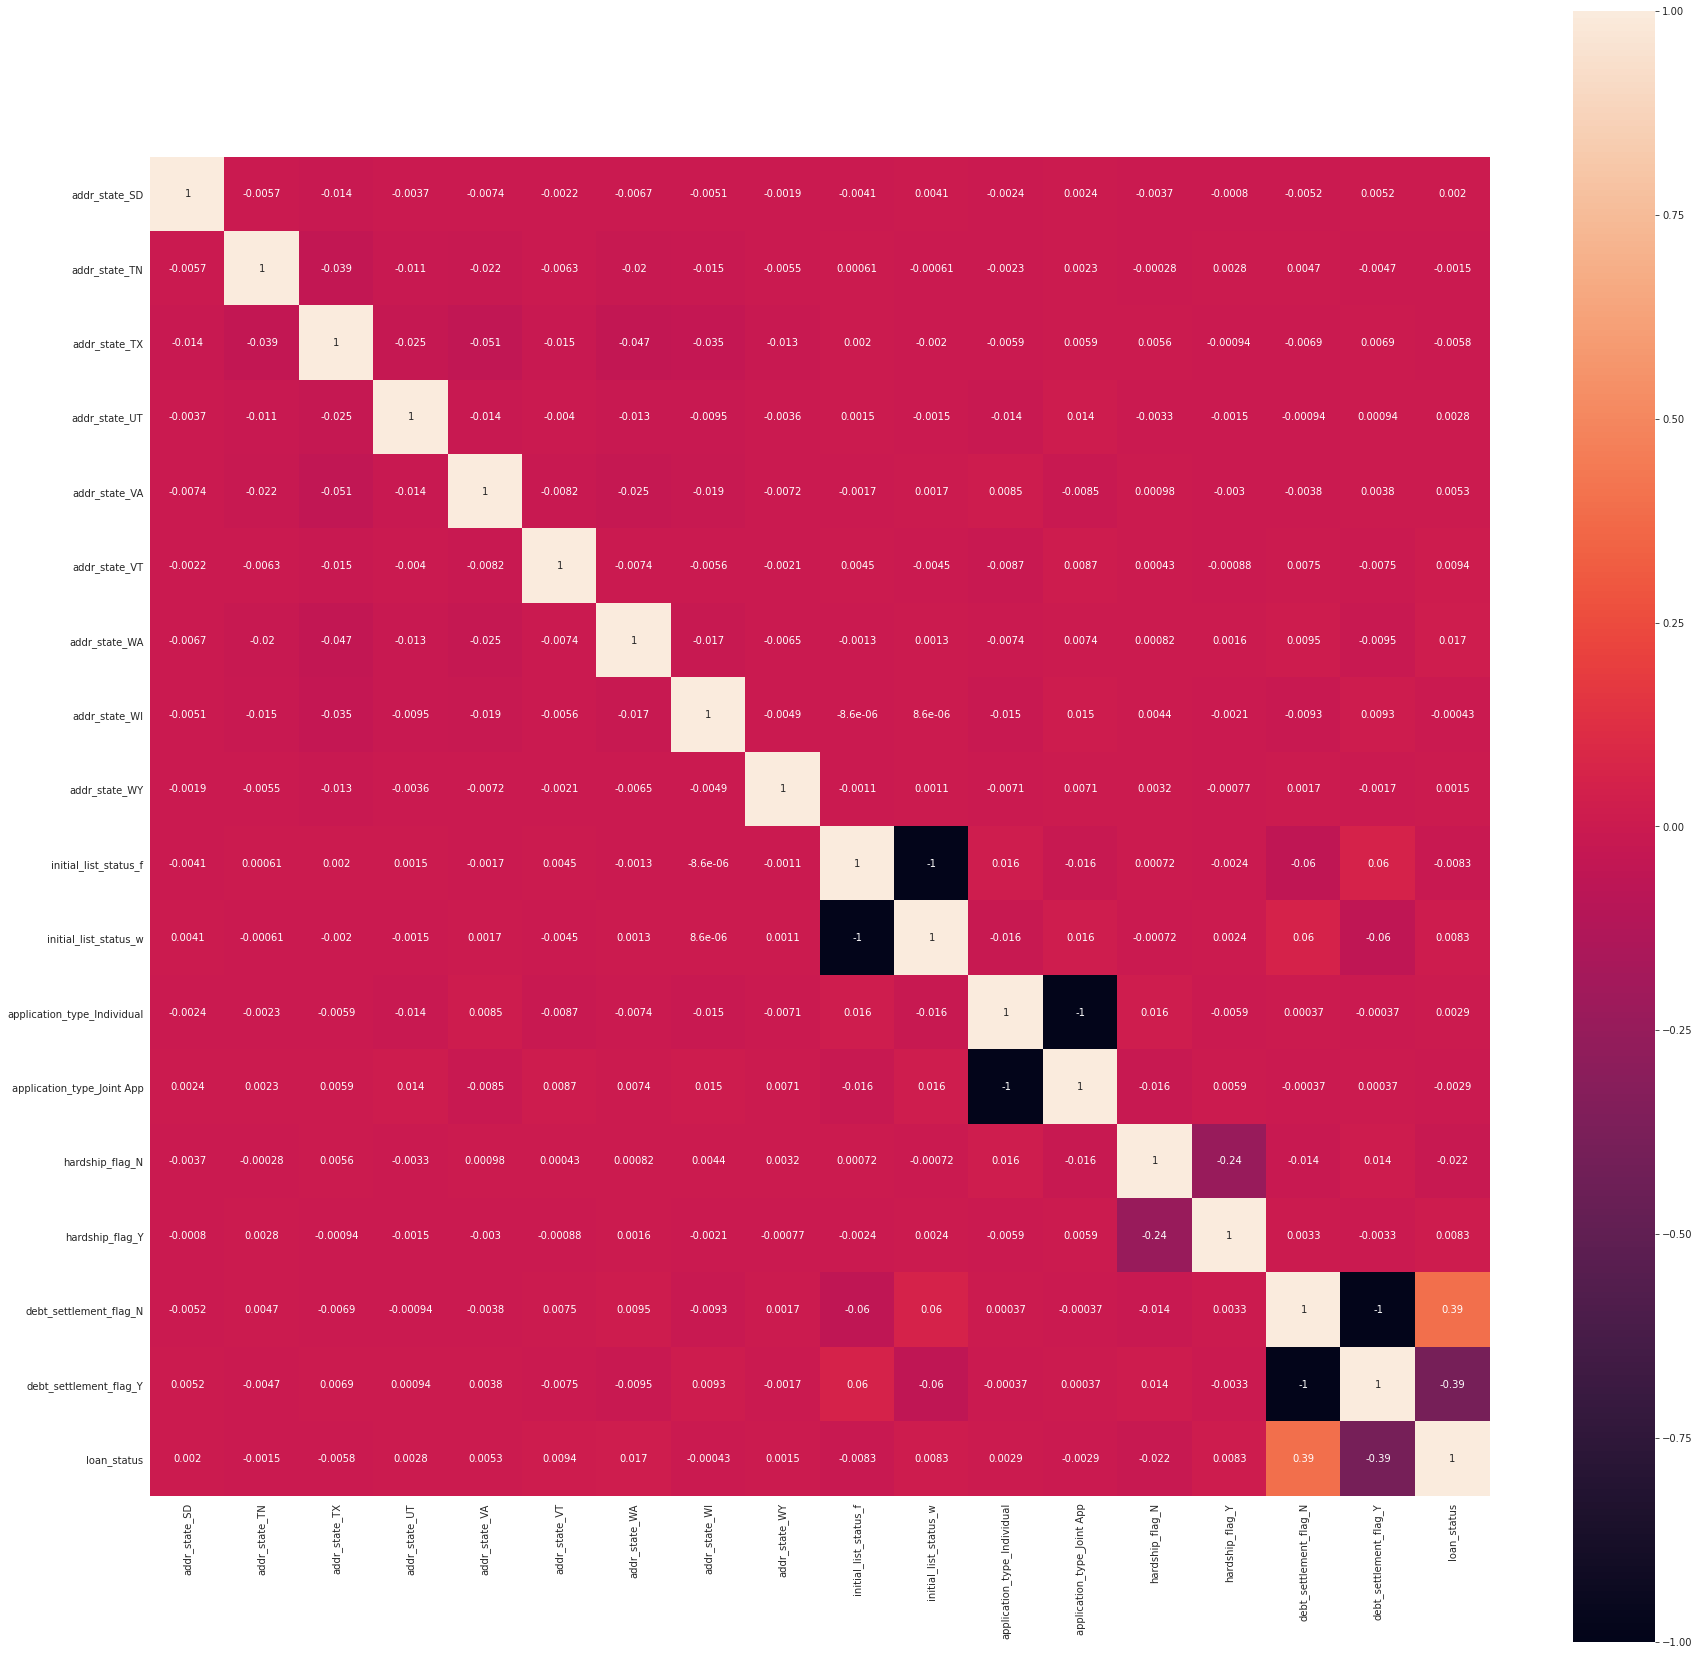

In [ ]:
# making pair plot for data_5

import seaborn as sns

plt.figure(figsize=(30,30))

sns.heatmap(data_5.corr(),annot = True , square = True)

# Distribution of Good and Band Loans after Data Cleaning and Feature Engineering

Text(0, 0.5, 'counts')

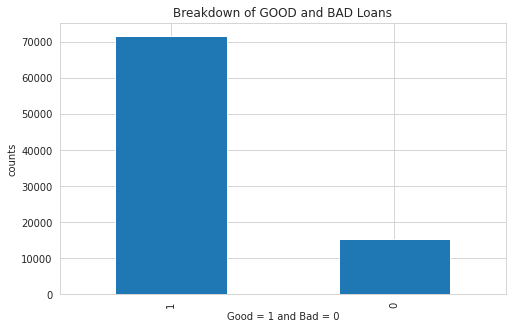

In [ ]:
plt.figure(figsize=(8,5))
ax = data['loan_status'].value_counts().plot(kind='bar',title='Breakdown of GOOD and BAD Loans'  )
ax.set_xlabel("Good = 1 and Bad = 0" )
ax.set_ylabel("counts")

# Splitting the data into train and test before feeding into the model

In [63]:
Y = data['loan_status']

X = data.drop('loan_status' , axis = 1)

scaler = StandardScaler()

In [64]:
data_normalized = scaler.fit_transform(X)

In [65]:
X_norm = pd.DataFrame(data_normalized , columns= X.columns)

In [66]:
X_train , X_test , Y_train , Y_test = train_test_split(X_norm , Y , test_size = 0.25 , random_state = 42 , stratify = Y )

#### **Running a preliminary screening of different algorithms to select best performing ones (based on AUC-ROC scoring) for further analysis and use.**

In [ ]:
models = [LogisticRegression(),DecisionTreeClassifier(),SVC() , \
          GradientBoostingClassifier(),RandomForestClassifier(n_estimators=100),\
          XGBClassifier() , GaussianNB()]

In [ ]:
list1 = []


In [ ]:
for model in models:
  model.fit(X_train , Y_train)
  score = cross_val_score(model , X_test , Y_test ,cv =10 , n_jobs = -1 , scoring='roc_auc').mean() 

  print (model, '\n ROC-AUC Score is', score)
  list1.append(score)

In [ ]:
Z = ['LogisticRegression','DecisionTreeClassifier','SVC' , \
          'GradientBoostingClassifier','RandomForestClassifier',\
          'XGBClassifier' , 'GaussianNB']

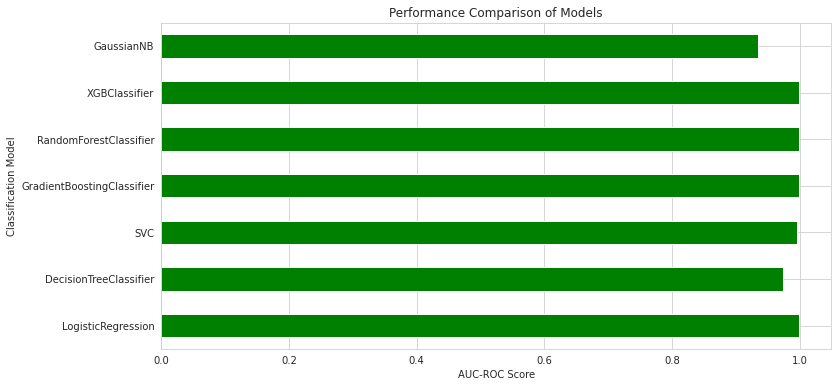

In [ ]:
modeldf = pd.DataFrame(
    {'Model': Z,
     'AUC-ROC Score': list1})

ax = modeldf.plot(kind='barh', title='Performance Comparison of Models',figsize=(12,6),legend=False,color='g')
ax.set_yticklabels(modeldf.Model)
ax.set_xlabel("AUC-ROC Score")
ax.set_ylabel("Classification Model")

plt.show()

## **Using Decision Tree Algorithm first**

In [ ]:
DecisionTreeClassifier()

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
train_accuracy = []

test_accuracy = []

for i in np.linspace(1, 6 , 6):
 tree = DecisionTreeClassifier(random_state=42)
 tree.fit(X_train , Y_train)
 train_predict = tree.predict(X_train)
 train_accuracy.append(accuracy_score(Y_train,train_predict))

 test_predict = tree.predict(X_test)
 test_accuracy.append(accuracy_score(Y_test,test_predict))

 

In [ ]:
train_accuracy

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [ ]:
test_accuracy

[0.9910249919455056,
 0.9910249919455056,
 0.9910249919455056,
 0.9910249919455056,
 0.9910249919455056,
 0.9910249919455056]

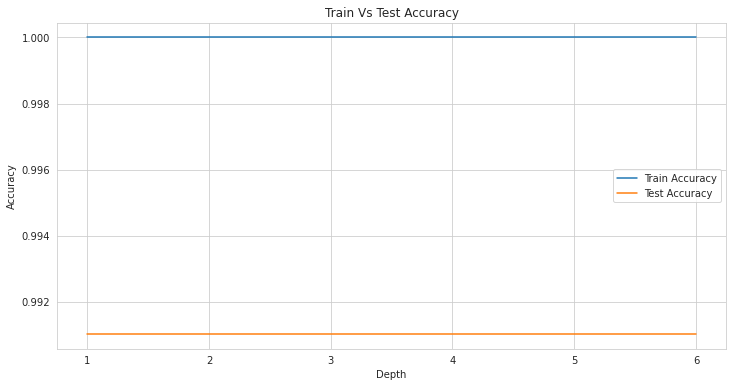

In [ ]:
#plot train and test accuracy
plt.figure(figsize=(12,6))
plt.plot(np.linspace(1,6,6),train_accuracy,label='Train Accuracy')
plt.plot(np.linspace(1,6,6),test_accuracy,label='Test Accuracy')
plt.title('Train Vs Test Accuracy')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#run a decision tree with max_depth = 3
clf = DecisionTreeClassifier(max_depth = 3, random_state = 42)
clf.fit(X_train,Y_train)
predict = clf.predict(X_test)
accuracy_score(Y_test,predict)

0.9486353385188936

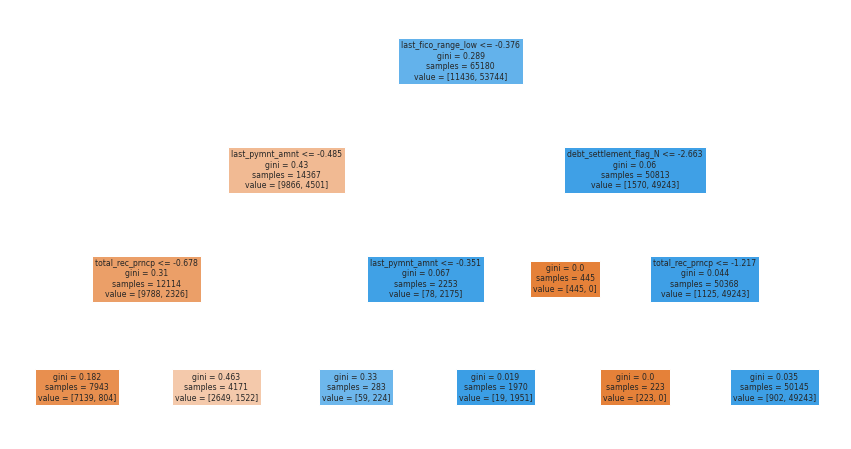

In [ ]:
#plot the tree
from sklearn import tree
plt.figure(figsize=(15,8))
tree.plot_tree(clf, feature_names=X.columns.to_list(), filled=True)
plt.show()

We can also check the feature importance of the variables in building the decision tree.

In [ ]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)
print(importances)




                    feature  importance
20      last_fico_range_low       0.710
18          last_pymnt_amnt       0.169
144  debt_settlement_flag_N       0.062
16          total_rec_prncp       0.060
100           addr_state_HI       0.000
..                      ...         ...
51                 num_sats       0.000
52       num_tl_op_past_12m       0.000
53           pct_tl_nvr_dlq       0.000
54         percent_bc_gt_75       0.000
145  debt_settlement_flag_Y       0.000

[146 rows x 2 columns]


As per above results :

1) last_fico_range_high , 

2) last_pymnt_amnt , 

3) debt_settlement_flag_Y ,

 4) total_rec_prncp 
 
 are the only influencing features 


In [ ]:
clf.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.05954408, 0.        , 0.16880125, 0.        ,
       0.70955145, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

# Evaluate the Decision Tree Classifier model 

In [ ]:
# Evaluate the model
#from sklearn.metrics import confusion_matrix
ConfusionMatrix = confusion_matrix(Y_test, test_predict)
score =clf.score(X_test, Y_test)


In [ ]:
score

0.9486353385188936

In [ ]:
ConfusionMatrix

array([[ 3727,    85],
       [  110, 17805]])

## 21532 records out of 21727 are predicted accurately by Decision Tree Classifier as above

In [5]:
def confm(x,y):
    conf_mat = confusion_matrix(x, y)
    fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(conf_mat, annot=True,fmt='g',
    yticklabels=['Defaulted', 'Fully Paid'], xticklabels=['Defaulted', 'Fully Paid'],cmap="gnuplot2_r")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

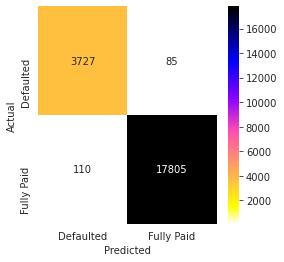

In [ ]:
confm(Y_test , test_predict)

In [ ]:
print(classification_report(Y_test , test_predict , target_names=['Defaulted','Fully Paid'] ))

              precision    recall  f1-score   support

   Defaulted       0.97      0.98      0.97      3812
  Fully Paid       1.00      0.99      0.99     17915

    accuracy                           0.99     21727
   macro avg       0.98      0.99      0.98     21727
weighted avg       0.99      0.99      0.99     21727



# Weighted Precision = 99%  ,  Weighted Recall = 99%  and Accuracy =  99%  for  Decision Tree Classifier

# K-Fold Cross Validation for Decision Tree Classifier 

In [ ]:
accuracies_dtc = cross_val_score(estimator = clf , X = X_train, y = Y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies_dtc.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_dtc.std()*100))

Accuracy: 94.98 %
Standard Deviation: 0.21 %


# Accuracy using K-Fold Validation for Decision Tree is 94.98% as above

## **Using Logistic Regression Algorithm**

In [67]:
lr = LogisticRegression()
lr.fit(X_train , Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
train_accuracy_lr = []

test_accuracy_lr  = []

In [ ]:
train_predict_lr = lr.predict(X_train)
train_accuracy_lr.append(accuracy_score(Y_train,train_predict_lr))

test_predict_lr = lr.predict(X_test)
test_accuracy_lr.append(accuracy_score(Y_test,test_predict_lr))


In [ ]:
train_accuracy_lr

[0.9976066277999386]

In [ ]:
test_accuracy_lr

[0.9968242279191789]

# Evaluate the Logistic Regression Model

In [ ]:
ConfusionMatrix_lr = confusion_matrix(Y_test, test_predict_lr)
score =lr.score(X_test, Y_test)

In [ ]:
score

0.9968242279191789

In [ ]:
ConfusionMatrix_lr

array([[ 3746,    66],
       [    3, 17912]])

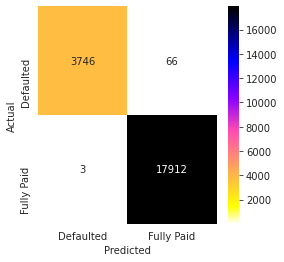

In [ ]:
confm(Y_test , test_predict_lr)

## 21658 records out of 21727 are predicted accurately by Logistic Regression model as above

In [ ]:
print(classification_report(Y_test , test_predict_lr , target_names=['Defaulted','Fully Paid'] ))

              precision    recall  f1-score   support

   Defaulted       1.00      0.98      0.99      3812
  Fully Paid       1.00      1.00      1.00     17915

    accuracy                           1.00     21727
   macro avg       1.00      0.99      0.99     21727
weighted avg       1.00      1.00      1.00     21727



# Weighted Precision = 100 % , Weighted Recall = 100%  and Accuracy =  100% for Logistic Regression 

Figuring out key decisive faetures while using Logistic Regression , FEature above importance level of 0.02 will be considered significant

# K-Fold Cross Validation for Logistic Regression Model

In [ ]:
accuracies_lr = cross_val_score(estimator = lr , X = X_train, y = Y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies_lr.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_lr.std()*100))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Accuracy: 99.72 %
Standard Deviation: 0.07 %


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#   Accuracy : 99.72 %  and Standard Deviation : 0.07% for Logistic Regression using K-Fold Cross Validation

## **Using Random Forest Classifier**

In [ ]:
rfc = RandomForestClassifier(random_state=1234)
rfc.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1234,
                       verbose=0, warm_start=False)

In [ ]:
train_accuracy_rfc = []

test_accuracy_rfc  = []

In [ ]:
train_predict_rfc = rfc.predict(X_train)
train_accuracy_rfc.append(accuracy_score(Y_train,train_predict_rfc))

test_predict_rfc = rfc.predict(X_test)
test_accuracy_rfc.append(accuracy_score(Y_test,test_predict_rfc))

In [ ]:
train_accuracy_rfc

[1.0]

In [ ]:
test_accuracy_rfc

[0.9931881990150504]

# Evaluating the Random Forest Classifier

In [ ]:
ConfusionMatrix_rfc = confusion_matrix(Y_test, test_predict_rfc)
score =rfc.score(X_test, Y_test)

In [ ]:
ConfusionMatrix_rfc

array([[ 3681,   131],
       [   17, 17898]])

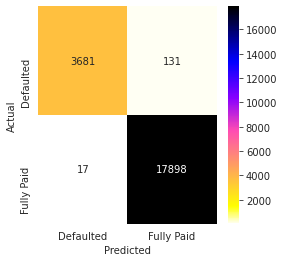

In [ ]:
confm(Y_test , test_predict_rfc)

## 21579 records out of 21727 are predicted accurately by Random Forest Classifier as above

In [ ]:
print(classification_report(Y_test , test_predict_rfc , target_names=['Defaulted','Fully Paid'] ))

              precision    recall  f1-score   support

   Defaulted       1.00      0.97      0.98      3812
  Fully Paid       0.99      1.00      1.00     17915

    accuracy                           0.99     21727
   macro avg       0.99      0.98      0.99     21727
weighted avg       0.99      0.99      0.99     21727



# Weighted Precision = 99 % , Weighted Recall = 99% and Accuracy = 99% for Random Forest Classifier

# K-Fold Cross Validation for Random Forest Classifier

In [ ]:
accuracies_rfc = cross_val_score(estimator = rfc , X = X_train, y = Y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies_rfc.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_rfc.std()*100))

Accuracy: 99.36 %
Standard Deviation: 0.09 %


# using K-Fold Cross Validation , accuracy for Random Forest Classifier = 99.41%

# **Using XGBoost Classifier**

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
train_accuracy_xgb = []

test_accuracy_xgb  = []

In [ ]:
train_predict_xgb = xgb.predict(X_train)
train_accuracy_xgb.append(accuracy_score(Y_train,train_predict_xgb))

test_predict_xgb = xgb.predict(X_test)
test_accuracy_xgb.append(accuracy_score(Y_test,test_predict_xgb))

In [ ]:
train_accuracy_xgb

[0.996440625958883]

In [ ]:
test_accuracy_xgb

[0.9950292263082801]

# Evaluating the XGBoost Classifier 

In [ ]:
ConfusionMatrix_xgb = confusion_matrix(Y_test, test_predict_xgb)
score =xgb.score(X_test, Y_test)

In [ ]:
ConfusionMatrix_xgb

array([[ 3708,   104],
       [    4, 17911]])

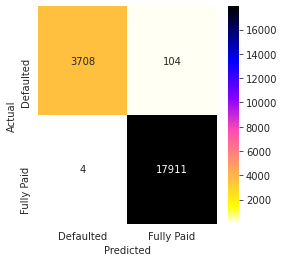

In [ ]:
confm(Y_test , test_predict_xgb)

## 21619 records out of 21727 are predicted accurately by XGBoost Classifier as above

In [ ]:
print(classification_report(Y_test , test_predict_xgb , target_names=['Defaulted','Fully Paid'] ))

              precision    recall  f1-score   support

   Defaulted       1.00      0.97      0.99      3812
  Fully Paid       0.99      1.00      1.00     17915

    accuracy                           1.00     21727
   macro avg       1.00      0.99      0.99     21727
weighted avg       1.00      1.00      1.00     21727



# Weighted Precision = 100% , Weighted Recall = 100% and Accuracy = 100% for XGBoost Classifier

# K-Fold Cross Validation for XGBoost Classifier

In [ ]:
accuracies_xgb = cross_val_score(estimator = xgb , X = X_train, y = Y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies_xgb.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies_xgb.std()*100))

Accuracy: 99.55 %
Standard Deviation: 0.07 %


# using K-Fold Cross Validation , accuracy for XGBoost Classifier = 99.55%

# **Results** 

# AUC ROC Curve for all the four used models

# Calculate AUROC

In [ ]:
dt_auc = roc_auc_score(Y_test, test_predict)
rf_auc = roc_auc_score(Y_test, test_predict_rfc)
lr_auc = roc_auc_score(Y_test, test_predict_lr)
xgb_auc = roc_auc_score(Y_test, test_predict_xgb)

# Print AUC ROC Score

In [ ]:
print('Decision Tree: AUROC = %.3f' % (dt_auc))
print('Random Forest: AUROC = %.3f' % (rf_auc))
print('Logistic Regression: AUROC = %.3f' % (lr_auc))
print('XGBoosting Classifier: AUROC = %.3f' % (xgb_auc))

Decision Tree: AUROC = 0.986
Random Forest: AUROC = 0.982
Logistic Regression: AUROC = 0.991
XGBoosting Classifier: AUROC = 0.986


# Calculate ROC Curve

In [ ]:
dt_fpr, dt_tpr, _ = roc_curve(Y_test, test_predict)
rf_fpr, rf_tpr, _ = roc_curve(Y_test, test_predict_rfc)
lr_fpr, lr_tpr, _ = roc_curve(Y_test, test_predict_lr)
xb_fpr, xb_tpr, _ = roc_curve(Y_test, test_predict_xgb)

# Plot the ROC Curve 

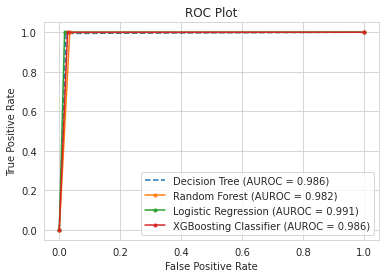

In [ ]:
plt.plot(dt_fpr, dt_tpr, linestyle='--', label='Decision Tree (AUROC = %0.3f)' %dt_auc)
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % rf_auc)
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression (AUROC = %0.3f)' % lr_auc)
plt.plot(xb_fpr, xb_tpr, marker='.', label='XGBoosting Classifier (AUROC = %0.3f)' % xgb_auc)

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

# AUC ROC curve is the highest for Logistic Regression , closely followed by Decision Tree and XGBoosting 

# Precision , Recall and Accuracy for all the 4 used models 

                                               

**Decision Tree Classifier**  :  Precision ->  99% ; Recall ->  99% ; Accuracy -> 99%

**Logistic Regression**  :       Precision ->   100% ; Recall ->  100%  ; Accuracy -> 100% 

**Random Forest Classifier** :    Precision ->   99% ; Recall ->  99% ; Accuracy ->  99%

**XGBoost Classifier**       :   Precision ->    100% ; Recall ->  100%  ; Accuracy -> 100% 

# K-Fold Cross Validation Results for all the 4 used models

**Decision Tree Classifier**  :  Accuracy -> 94.98%  ; Standard Deviation -> 0.21%

**Logistic Regression**  :        Accuracy -> 99.72% ; Standard Deviation -> 0.07% 

**Random Forest Classifier** :    Accuracy -> 99.36% ; Standard Deviation -> 0.09%

**XGBoost Classifier**       :    Accuracy -> 99.55% ; Standard Deviation -> 0.07%

**As per the Observations above, Logistic Regression is the best model to be used in this Loan Prediction Scenario as its Precision , Recall ,  Accuracy and AUC ROC values are higher than all three models.**

  

**The Second best model to be used is the XGBoost Classifier as its Precision , Recall and Accuracy Values are higher than Random Forest and Decision Tree Classifier.**

# **Comparing Logistic Regression with XGBoosting Classifier :**



*  **K-Fold Validation Accuracy(99.72%) for Logistic Regression is higher than K-Fold Accuracy(99.55%) for XGBoosting Classifier.** 
*   **The Precision value for Fully Paid loan status and recall value for Defaulted Loan Status is higher for Logistic Regression as compared to XGBoosting Classifier**
*  **AUC ROC Curve score is higher for Logistic Regression as comapred to XGBoosting Classifier**





 


## **Deployment of best performing model "Logistic Regression" to AWS Cloud**

# Important features for Logistic Regression

In [ ]:
from sklearn.datasets import make_classification

 #define dataset
X_train , Y_train = make_classification(n_samples=1000, n_features=146, n_informative=5, n_redundant=5, random_state=1)
# define the model
model = LogisticRegression()
# fit the model
model.fit(X_train, Y_train)
# get importance
importance = model.coef_[0]




#top_features = importance.sort()

 #summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v)) 
 # plot feature importance
#plt.bar([x for x in range(len(importance))], importance)
#plt.show()

Feature: 0, Score: 0.09290
Feature: 1, Score: 0.08680
Feature: 2, Score: -0.09837
Feature: 3, Score: -0.19170
Feature: 4, Score: -0.02426
Feature: 5, Score: -0.00616
Feature: 6, Score: -0.13875
Feature: 7, Score: 0.06375
Feature: 8, Score: -0.02135
Feature: 9, Score: -0.07824
Feature: 10, Score: -0.17914
Feature: 11, Score: 0.23477
Feature: 12, Score: -0.77497
Feature: 13, Score: -0.13045
Feature: 14, Score: 0.14202
Feature: 15, Score: -0.08187
Feature: 16, Score: 0.03835
Feature: 17, Score: -0.24058
Feature: 18, Score: -0.02540
Feature: 19, Score: -0.05847
Feature: 20, Score: -0.63163
Feature: 21, Score: -0.17621
Feature: 22, Score: -0.17528
Feature: 23, Score: -0.07760
Feature: 24, Score: -0.17031
Feature: 25, Score: -0.12390
Feature: 26, Score: 0.07527
Feature: 27, Score: 0.07028
Feature: 28, Score: 0.22809
Feature: 29, Score: -0.07867
Feature: 30, Score: -0.13809
Feature: 31, Score: 0.28207
Feature: 32, Score: 0.07653
Feature: 33, Score: 0.19183
Feature: 34, Score: -0.20194
Feature

**Feature no 12 , 20 , 44 , 63 , 129 have cofficients greater than 0.5 or less than -0.5 so are most significant** 

**Feature no 119 and 57 have cofficients greater than .33** 

**Feature 31 , 100 and 96 have cofficients greater than  .26**

In [ ]:
X_norm.columns[12]

'revol_util'

In [ ]:
X_norm.columns[20]

'last_fico_range_low'

In [ ]:
X_norm.columns[44]

'num_actv_rev_tl'

In [ ]:
X_norm.columns[63]

'grade_C'

In [ ]:
X_norm.columns[129]

'addr_state_SD'

In [ ]:
X_norm.columns[119]

'addr_state_NJ'

In [ ]:
X_norm.columns[57]

'total_bc_limit'

In [ ]:
X_norm.columns[31]

'total_rev_hi_lim'

In [ ]:
X_norm.columns[100]

'addr_state_HI'

In [ ]:
X_norm.columns[96]

'addr_state_DC'

In [ ]:
#imp_lr = [ ]
#imp

#i = 0

#for i < 20:


In [ ]:
#imp_lr.append(importance[0])

In [ ]:
X_norm.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,emp_length,annual_inc,dti,fico_range_low,fico_range_high,open_acc,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,policy_code,tot_cur_bal,open_act_il,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,...,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WY,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App,hardship_flag_N,hardship_flag_Y,debt_settlement_flag_N,debt_settlement_flag_Y
0,-0.023675,-0.023675,-0.023169,-0.079885,-0.443199,0.732915,-0.142338,-0.739370,0.565629,0.565610,-0.654336,-0.577410,-1.140306,-0.243634,-0.795027,-0.794867,-0.923406,0.154618,-0.650485,-2.160657,-1.254387,0.0,-0.814020,-0.598961,-0.355435,-0.312170,-0.637190,0.176950,-0.691731,-0.449418,-0.786632,-0.547071,-0.876648,-0.814389,-0.749041,-0.043847,-1.196489,-1.741006,1.389698,0.586521,...,-0.106076,-0.152374,-0.158737,-0.055513,-0.161271,-0.135989,-0.128744,-0.07944,-0.053819,-0.167582,-0.046561,-0.070268,-0.074133,-0.19345,-0.069185,-0.120655,-0.301119,-0.182357,-0.095656,-0.114777,-0.186625,-0.069603,-0.109785,-0.044402,-0.128559,-0.306834,-0.082676,-0.167364,-0.048744,6.581618,-0.114519,-0.042947,-0.67347,0.67347,0.208811,-0.208811,0.074368,-0.017952,0.181547,-0.181547
1,-0.454372,-0.454372,-0.454044,-1.112658,-0.462729,-0.878010,-0.142157,0.630812,1.801408,1.801359,0.217963,-0.364201,-1.256687,-0.412033,-0.376028,-0.375702,-0.246519,-0.626972,0.188881,1.282462,0.891739,0.0,-0.667138,0.068157,0.314974,-0.195883,-0.189142,-0.138898,0.074838,-0.544391,-0.786632,0.223150,-0.448090,0.118766,-0.666933,0.406549,-1.207243,-0.771983,-0.942179,-0.736529,...,-0.106076,-0.152374,-0.158737,-0.055513,-0.161271,-0.135989,-0.128744,-0.07944,-0.053819,-0.167582,-0.046561,-0.070268,-0.074133,-0.19345,-0.069185,-0.120655,-0.301119,-0.182357,-0.095656,-0.114777,5.358339,-0.069603,-0.109785,-0.044402,-0.128559,-0.306834,-0.082676,-0.167364,-0.048744,-0.151938,-0.114519,-0.042947,-0.67347,0.67347,0.208811,-0.208811,0.074368,-0.017952,0.181547,-0.181547
2,-0.131350,-0.131350,-0.130888,-0.335619,-0.058689,1.001402,-0.121719,-0.618590,1.337991,1.337953,-0.130957,-0.181532,-0.662313,-0.075236,0.051099,0.051594,0.076975,0.041288,-0.634543,1.219860,0.852718,0.0,-0.778770,-0.598961,-0.355435,0.075454,-0.710634,-0.454745,-1.075016,0.475366,-0.981501,0.058501,-0.448090,-1.125441,-0.704848,0.181940,-0.755587,0.425046,-0.104319,1.334332,...,-0.106076,-0.152374,-0.158737,-0.055513,-0.161271,-0.135989,-0.128744,-0.07944,-0.053819,-0.167582,-0.046561,-0.070268,-0.074133,-0.19345,-0.069185,-0.120655,-0.301119,-0.182357,-0.095656,-0.114777,-0.186625,-0.069603,-0.109785,-0.044402,-0.128559,-0.306834,-0.082676,-0.167364,-0.048744,-0.151938,-0.114519,-0.042947,-0.67347,0.67347,0.208811,-0.208811,0.074368,-0.017952,0.181547,-0.181547
3,-1.205400,-1.205400,-1.205383,-1.211017,-1.212357,1.001402,0.007720,0.177284,-0.052260,-0.052264,0.217963,1.277766,0.742571,0.008964,-1.079312,-1.079265,-0.998644,-0.850038,-0.682491,0.218225,0.228391,0.0,0.143855,0.401716,0.314974,-0.157121,-0.432709,1.214736,-0.691731,1.132360,0.723604,0.918023,-0.019533,-0.503337,-0.040923,0.130351,0.420150,-0.353973,0.854679,-0.563957,...,-0.106076,-0.152374,-0.158737,-0.055513,-0.161271,-0.135989,-0.128744,-0.07944,-0.053819,-0.167582,-0.046561,-0


# I am considering following features as important for Logistic Regression :

**revol_util**

**last_fico_range_low**

**num_actv_revl_tl** 

**total_bc_limit**

**total_rev_hi_lim**


# other some important features :

**loan_amnt -> 0.92(cofficient)**

**int_rate  -> 0.13**

**annual_inc ->  -.13** 

**total_pymnt ->  0.14** 





# Not considering GRADE feature as grade is some what correlated with int_rate 

# Not Considering ADDR_STATE feature as well

In [68]:
imp_feature_lr = ["revol_util" , "last_fico_range_low" , "num_actv_rev_tl" , "total_bc_limit" , "total_rev_hi_lim" , 
                   "loan_amnt"  ,  "int_rate" , "annual_inc" , "total_pymnt"]

In [69]:
X_norm_lr = X_norm[imp_feature_lr]

In [70]:
X_norm_lr.shape

(86907, 9)

# Split train and test data with selected 9 features as above

In [71]:
X_train_lr , X_test_lr , Y_train_lr , Y_test_lr = train_test_split(X_norm_lr , Y , test_size = 0.25 , random_state = 42 , stratify = Y )

In [72]:
lr1 = LogisticRegression()
lr1.fit(X_train_lr , Y_train_lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [74]:

train_accuracy_lr1 = []

test_accuracy_lr1 = []


In [75]:
train_predict_lr1 = lr1.predict(X_train_lr)
train_accuracy_lr1.append(accuracy_score(Y_train,train_predict_lr1))

test_predict_lr1 = lr1.predict(X_test_lr)
test_accuracy_lr1.append(accuracy_score(Y_test,test_predict_lr1))


In [ ]:
train_accuracy_lr1

[0.9810831543418227, 0.9810831543418227]

In [ ]:
test_accuracy_lr1

[0.981037418879735]

In [76]:
ConfusionMatrix_lr1 = confusion_matrix(Y_test, test_predict_lr1)
score1 =lr1.score(X_test_lr, Y_test_lr)

In [ ]:
ConfusionMatrix_lr1

array([[ 3463,   349],
       [   63, 17852]])

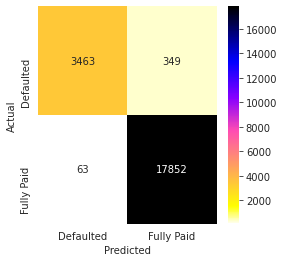

In [77]:
confm(Y_test_lr , test_predict_lr1)

In [78]:
score1

0.981037418879735

## Saving Logistic Regression Model to Disk

In [79]:
pickle.dump(lr1 , open('lr1.pkl', 'wb'))